# Manuscript Figures
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  01/04/2025          |
| Updated |  01/24/2025          |

# Methodology

## Radiation Transport

### Athena++

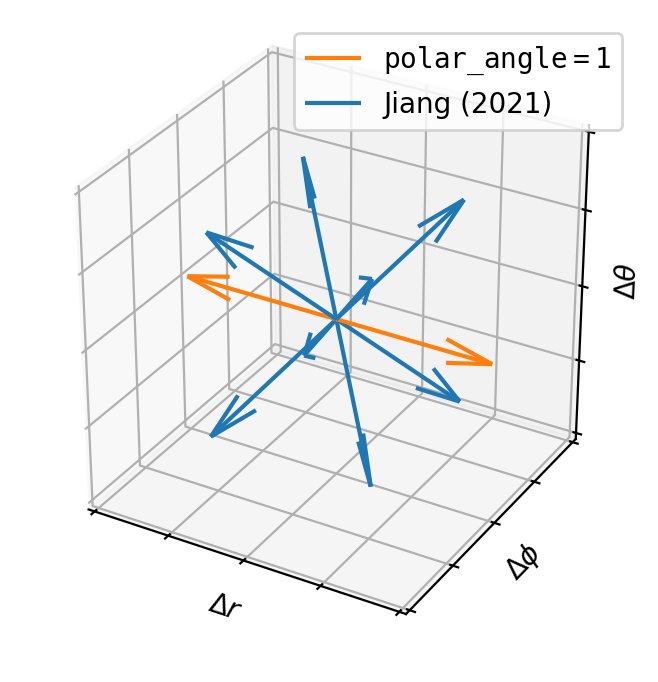

In [1]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np

def AngGrid(nzeta = 3, npsi = 2):
    fracs = np.arange((nzeta - 2), -1, -2)/nzeta
    thetaf = np.arccos(fracs)
    thetaf = np.append(thetaf, (np.pi-np.flip(thetaf)))
    thetaf = np.insert(thetaf, [0, thetaf.size], [0, np.pi])
    cos_thetaf = np.cos(thetaf)
    thetav = np.arccos((cos_thetaf[:-1] + cos_thetaf[1:])/2)
    phif = np.linspace(0, 2*np.pi, 2*npsi+1)
    phiv = (phif[:-1] + phif[1:])/2
    thetamesh, phimesh = np.meshgrid(thetav, phiv)
    mu_x = np.sin(thetamesh)*np.cos(phimesh)
    mu_y = np.sin(thetamesh)*np.sin(phimesh)
    mu_z = np.cos(thetamesh)

    return mu_x, mu_y, mu_z

# Make the grid
nzeta = 3
npsi = 2
mu_x, mu_y, mu_z = AngGrid(nzeta, npsi)
x, y, z = np.zeros_like(AngGrid(nzeta, npsi))

# Plot
ax = plt.figure(figsize=(4, 4), dpi=200).add_subplot(projection='3d')
ax.quiver([0, 0], [0, 0], [0, 0], [-1, 1], [0, 0], [0, 0], color='tab:orange',
          label=r'$\mathtt{polar\_angle = 1}$')
ax.quiver(x[:,0], y[:,0], z[:,0], mu_x[:,0], mu_y[:,0], mu_z[:,0],
          label='Jiang (2021)')
ax.quiver(x[:,2], y[:,2], z[:,2], mu_x[:,2], mu_y[:,2], mu_z[:,2])
ax.legend()
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), aspect='equal',
       xticklabels=[], yticklabels=[], zticklabels=[],)
ax.set_xlabel(r'$\Delta r$', labelpad=-10)
ax.set_ylabel(r'$\Delta \phi$', labelpad=-10)
ax.set_zlabel(r'$\Delta \theta$', labelpad=-10)
plt.savefig(f'figs/angular_grid.pdf', bbox_inches='tight', pad_inches=0.01)

## Band-Mean Opacities

### [Quantities](https://github.com/PrincetonUniversity/athena/wiki/Non-relativistic-Radiation-Transport#units)

- Code Units
  - Temperature $T_0$
  - Density $\rho_0$
  - Length $L_0$
  - Time $t_0 = L_0 / v_0 = \mathbb{C}L_0 / c$
- Ideal Gas
  - Constant mean molecular weight $\mu$
  - Atomic mass constant $m_\mathrm{u}$
  - Gas velocity (isothermal sound speed) $v_0 = c_\mathrm{s,iso} = \sqrt{k_\mathrm{B} T_0 / (\mu m_\mathrm{u})}$
  - Pressure $P_0 \equiv k_\mathrm{B}\rho_0 T_0 / (\mu m_\mathrm{u}) = \rho_0 R_\mathrm{ideal} T_0$
  - Internal energy $E_\mathrm{g} = P/(\gamma_\mathrm{g} - 1)$ for adiabatic index $\gamma_\mathrm{g} \neq 1$
  - Temperature $T = P/(R_\mathrm{ideal}\rho) = E_\mathrm{g}(\gamma_\mathrm{g} - 1)/(R_\mathrm{ideal}\rho)$
- Radiation
  - Specific intensity $I\,[a_\mathrm{r}T_0^4]$
  - Energy density $E_\mathrm{r} = \int I\mathrm{d}\Omega$ (taking $4\pi = 1$)
  - Flux $\mathbf{F}_\mathrm{r} = \int\mathbf{n}I\mathrm{d}\Omega$ (units of $ca_\mathrm{r}T_0^4$)
- Dimensionless
  - $\mathbb{C} = \mathcal{C} \equiv c/v_0 = c/c_\mathrm{s,iso}$
  - $\mathbb{P} = \mathcal{P} \equiv a_\mathrm{r}T_0^4 / P_0 = a_\mathrm{r}T_0^4 / (\rho_0 R_\mathrm{ideal} T_0)$
- Sums
  - Total pressure (energy) $P_\mathrm{g} + \mathbb{P}P_\mathrm{r}\,[P_0]$
  - Total momentum $\rho v + F_\mathrm{r}\mathbb{P}/\mathbb{C}\,[\rho_0 v_0]$

In [2]:
# BEGIN /athinput.[pgen]
# <radiation>
T_unit           = 6.14e3              # T_0 [K]
density_unit     = 4.28e-14            # \rho_0 [g/cm^3]
molecular_weight = 0.6                 # \mu
# END /athinput.[pgen]

# BEGIN athena/src/nr_radiation/radiation.cpp
# NRRadiation::NRRadiation(...) {
#   // universal constants we need
#   // https://physics.info/constants/
#   // arad = 4 * sigma/c
arad = 7.565733250033928e-15
c_speed = 2.99792458e10 # // speed of light

tunit = T_unit                # pin->GetOrAddReal("radiation","T_unit",1.e7);
rhounit = density_unit        # pin->GetOrAddReal("radiation","density_unit",1.0);
mol_weight = molecular_weight # pin->GetOrAddReal("radiation","molecular_weight",0.6);

# ...
#   }  else if (user_unit_ == 1) {
#      // calculate prat and crat based on user provided unit
r_ideal = 8.314462618e7/mol_weight
prat = arad * tunit * tunit * tunit/(rhounit * r_ideal)
cs_iso = (r_ideal * tunit)**(1/2)
crat = c_speed/cs_iso
# END athena/src/nr_radiation/radiation.cpp

# Extra conversions
m_u              = 1.66e-24            # atomic mass constant [g]
k_B              = 1.38e-16            # Boltzmann constant [erg/K]
P_0 = density_unit*r_ideal*T_unit
P_0alt = k_B*density_unit*T_unit/molecular_weight/m_u
prat_check = arad*T_unit**4/P_0

print(f'prat = {prat:.2e}')
print(f'crat = {crat:.2e}')
print(rf' P_0 = \rho_0*R_ideal*T_0       = {P_0:.2e} g/cm/s^2')
print(rf' P_0 = k_B*\rho_0*T_0/(\mu*m_u) = {P_0alt:.2e} g/cm/s^2')
print(f'(prat_check = a_r*T_0^4/P_0 = {prat_check:.2e})')


prat = 2.95e+02
crat = 3.25e+04
 P_0 = \rho_0*R_ideal*T_0       = 3.64e-02 g/cm/s^2
 P_0 = k_B*\rho_0*T_0/(\mu*m_u) = 3.64e-02 g/cm/s^2
(prat_check = a_r*T_0^4/P_0 = 2.95e+02)


### Planck mean opacity

To properly use the multigroup radiation transport module for Athena++ (Jiang [2024](https://ui.adsabs.harvard.edu/abs/2022ApJS..263....4J/abstract)), we must compute in advance the Planck mean $\kappa_{\mathrm{p},f}$ and Rosseland mean $\kappa_{\mathrm{a},f}$ absorption opacities for each frequency band $f$.
In this context, the Planck mean absorption opacity (or *coefficient*) is defined as (Jiang [2024](https://ui.adsabs.harvard.edu/abs/2022ApJS..263....4J/abstract), eq. 14)
\begin{equation*}
    \kappa_{\mathrm{p},f} \equiv \frac{\int_{\nu_f}^{\nu_{f+1}}\kappa_{\mathrm{a},\nu}B_\nu(T)\mathrm{d}\nu}{\int_{\nu_f}^{\nu_{f+1}}B_\nu(T)\mathrm{d}\nu},
\end{equation*}
where $\nu_f$ and $\nu_{f+1}$ are the lower and upper limits of frequency band $f$,respectively, $\kappa_{\mathrm{a},\nu}$ is the monochromatic absorption opacity at frequency $\nu$, and $B_\nu(T)$ is the Planck law expressed as a function of absolute temperature $T$ (Rybicki & Lightman [1979](https://ui.adsabs.harvard.edu/abs/1979rpa..book.....R/abstract), eq. 1.51)
\begin{equation*}
    B_\nu(T) = \frac{2h\nu^3/c^2}{\exp(h\nu/kT) - 1}, \\
\end{equation*}
where $h$ is the Planck constant, $c$ is the speed of light, $k$ is the Boltzmann constant.
Letting
\begin{align*}
    A_1 &\equiv \frac{2h}{c^2}\left(\frac{kT}{h}\right)^3 = \frac{2(kT)^3}{(hc)^2}, \\
    u &\equiv \frac{h\nu}{kT},
\end{align*}
the Planck law can be rewritten as
\begin{equation*}
    B_\nu(u) = A_1\frac{u^3}{e^u -1}.
\end{equation*}

#### Rayleigh–Jeans and Wien laws

For $hv \ll kT$ (i.e. $u \ll 1$), first-order expansion of the exponential term in the denominator yields $e^u - 1 \approx u$, and the *Rayleigh–Jeans law* is (cf. Rybicki & Lightman 1979, eq. 1.53),
\begin{equation*}
    \lim_{u \to 0}B_\nu(u) = A_1u^2.
\end{equation*}
For $hv \gg kT$ (i.e. $u \gg 1$), the term unity in the denominator can be ignored compared to $e^u$, and the *Wien law* is (cf. Rybicki & Lightman 1979, eq. 1.54),
\begin{equation*}
    \lim_{u \to \infty}B_\nu(u) = A_1u^3e^{-u}.
\end{equation*}

#### Rosseland mean opacity

The Rosseland mean absorption opacity (or *coefficient*) is defined as (Jiang [2024](https://ui.adsabs.harvard.edu/abs/2022ApJS..263....4J/abstract), eq. 14)
\begin{equation*}
    \frac{1}{\kappa_{\mathrm{a},f}} \equiv \frac{\int_{\nu_f}^{\nu_{f+1}}\kappa_{\mathrm{a},\nu}^{-1}\frac{\partial B_\nu}{\partial T}\mathrm{d}\nu}{\int_{\nu_f}^{\nu_{f+1}}\frac{\partial B_\nu}{\partial T}\mathrm{d}\nu},
    \tag{1}
\end{equation*}
where the corresponding weighting function is the partial derivative of the Planck law with respect to temperature (Rybicki & Lightman [1979](https://ui.adsabs.harvard.edu/abs/1979rpa..book.....R/abstract), eq. 1.55)
\begin{align*}
    \frac{\partial B_\nu}{\partial T} &= \frac{2h^2\nu^4}{c^2kT^2}
        \frac{\exp(h\nu/kT)}{\left[\exp(h\nu/kT) - 1\right]^2} \\
    &= A_2\frac{u^4e^u}{(e^u - 1)^2},
    \tag{2}
\end{align*}
where
\begin{equation*}
    A_2 \equiv \frac{2h^2}{c^2kT^2}\left(\frac{kT}{h}\right)^4 = 2k^3\left(\frac{T}{hc}\right)^2.
\end{equation*}
To avoid a floating-point overflow or dividing by zero in machine-precision when computing equations (2) and (1), respectively, we evaluate two limits of equation (2): when $h\nu \ll kT$ and when $h\nu \gg kT$.
Thus,
\begin{equation*}
    \lim_{u\to0}\frac{\partial B_\nu}{\partial T} = A_2(u^2 - u^4),
\end{equation*}
and
\begin{equation*}
    \lim_{u\to\infty}\frac{\partial B_\nu}{\partial T} = A_2u^4e^{-u}.
\end{equation*}

In [3]:
#===============================================================================
import numpy as np
from pathlib import Path
from radmc3dPy import analyze
from scipy import integrate
from scipy.constants import c, h, k

# Convert constants from SI to cgs
c *= 1e2
h *= 1e7
k *= 1e7

def GetBnu_table(Ts, nus):
    """Computes Planck's law for a table of temperatures and frequencies
    """
    table = np.zeros((len(Ts), len(nus)))

    for i, T in enumerate(Ts):
        for j, nu in enumerate(nus):
            prefactor = 2*(k*T)**3/(h*c)**2
            u = h*nu/k/T
            if u < 0.001:  # Rayleigh--Jeans Law
                table[i][j] = prefactor*u**2
            elif u > 15:   # Wien Law
                table[i][j] = prefactor*u**3*np.exp(-u)
            else:          # Planck Law
                table[i][j] = prefactor*u**3/(np.exp(u) - 1)

    return table

def GetdBnu_dT_table(Ts, nus, diag=False):
    """Computes the partial derivative of Planck's law with respect to
    temperature
    """
    table = np.zeros((len(Ts), len(nus)))

    for i, T in enumerate(Ts):
        for j, nu in enumerate(nus):
            prefactor = 2*k**3*(T/h/c)**2
            u = h*nu/k/T
            if u < 0.001:
                table[i][j] = prefactor*(u**2 - u**4)
            elif u > 15:
                table[i][j] = prefactor*u**4*np.exp(-u)
            else:
                table[i][j] = prefactor*u**4*np.exp(u)/(np.exp(u) - 1)**2

    return table

def BinarySearchIncreasing(arr, low, high, target):
    """Iterative binary search on a strictly increasing array.

    Iteratively use binary search on a strictly increasing array to find the
    index that right-brackets the target, arr[mid-1] < target < arr[mid]
    """    
    while (low <= high):
        mid = int(low + (high - low)//2)
        if ((arr[mid-1] < target) and (target < arr[mid])):
            return mid
        elif (arr[mid] < target):
            low = mid
        else:
            high = mid

    raise Exception("Array may not be strictly increasing")

def FindLogUniformIndex(arr, target, dlog):
    """Returns the index that right-brackets the target in the array.

    NOTE: This function assumes array `arr` is uniformly spaced in logarithmic
    space.
    """
    index = int(np.log(target) - np.log(arr[0])//dlog) + 1

    return index

def PlanckMeanOpacities(kappa_nu, Bnu, nu, temp_table):
    numer = integrate.simpson(kappa_nu*Bnu, x=nu)
    denom = integrate.simpson(Bnu, x=nu)
    kappa = numer/denom
    np.nan_to_num(kappa, copy=False, nan=kappa_nu[0])
    return kappa

def RosselandMeanOpacities(kappa_nu, dBnu_dT, nu):
    numer = integrate.simpson(dBnu_dT/kappa_nu, x=nu)
    denom = integrate.simpson(dBnu_dT, x=nu)
    kappa = denom/numer
    np.nan_to_num(kappa, copy=False, nan=kappa_nu[0], posinf=kappa_nu[0])
    return kappa

def GetFreqGroup(nu_grid, nu):
    if nu < nu_grid[1]:
        return 0
    elif nu > nu_grid[-1]:
        return len(nu_grid) - 1
    else:
        # return BinarySearchIncreasing(nu_grid, 1, len(nu_grid) - 2, nu)
        for i, nu_i in enumerate(nu_grid[1:-1]):
            if nu > nu_i and nu < nu_grid[i+2]:
                return i+1

# Read absorption coefficient as a function of frequency
fname = list(Path('./').glob(f'dustkappa_*.inp'))[0].parts[0]
ext = fname[10:-4]
opac = analyze.readOpac(ext=[f'{ext}'])
opac_freq = np.flip(1e4*c/opac.wav[0])
opac_kabs = np.flip(opac.kabs[0])
opac_ksca = np.flip(opac.ksca[0])
scattering = False
if len(opac_ksca) == len(opac_kabs):
    scattering = True
    opac_comb = opac_kabs + opac_ksca

Reading dustkappa_dsharp.inp


ν_peak(T_s) = 3.40e+14 Hz = 0.88 μm


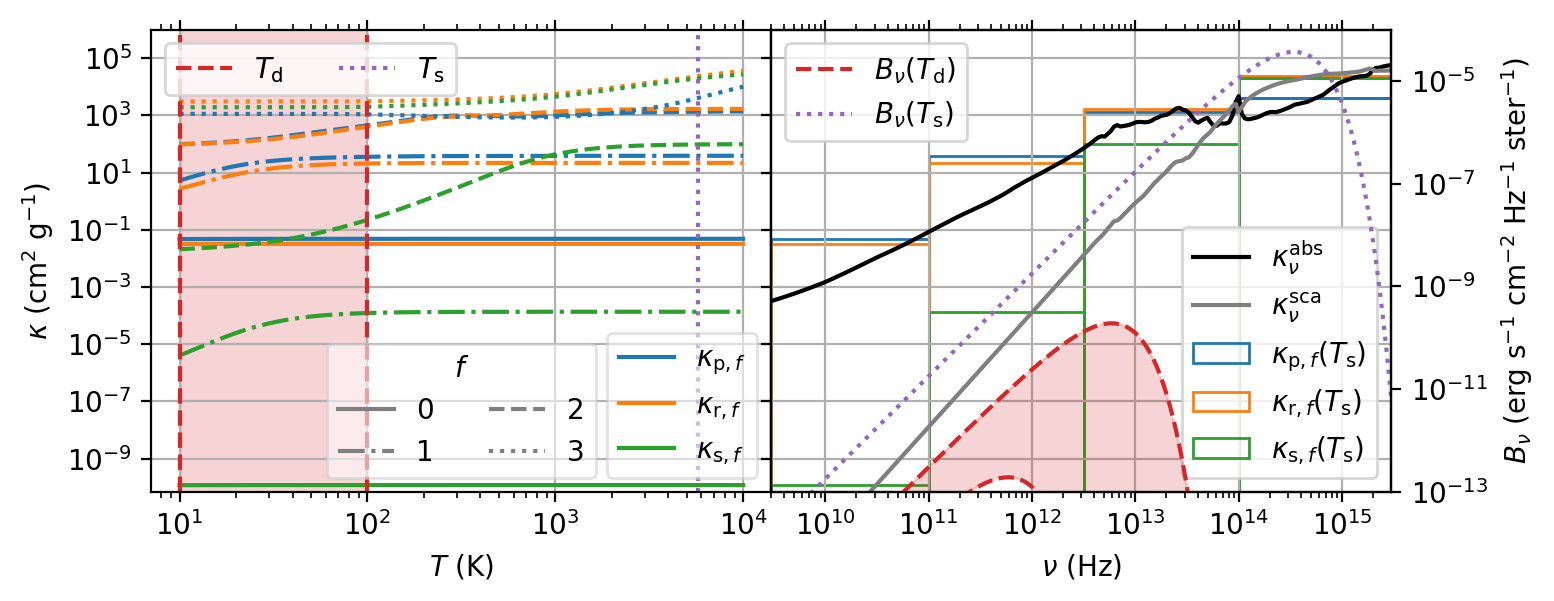

In [4]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import warnings

# Path
problem_id = 'dsharp'
base = 'nfreq'
ver = '4'
path = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'\
       +f'/dsharp_abs-sca/{base}/{ver}'

# Make tables to compute and save mean opacities
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
T_unit = athinput['radiation']['T_unit']                           # [K]
density_unit = athinput['radiation']['density_unit']               # [g/cm^3]
length_unit = athinput['radiation']['length_unit']                 # [cm]
ntemp = athinput['problem']['n_temperature']
temperature_min = athinput['problem']['temperature_min']           # [K]
temperature_max = athinput['problem']['temperature_max']           # [K]
temp_table = np.logspace(np.log10(temperature_min), np.log10(temperature_max),
                         ntemp)
Bnu_table = GetBnu_table(temp_table, opac_freq)
dBnu_dT_table = GetdBnu_dT_table(temp_table, opac_freq)

# For a single or multiple frequency bands
nu_min, nu_max = opac_freq[0], opac_freq[-1]
xlim = (nu_min, nu_max)
nfreq = athinput['radiation']['n_frequency']
kappa_pf_table = np.zeros((ntemp, nfreq))
kappa_rf_table = np.zeros((ntemp, nfreq))
if scattering:
    kappa_sf_table = np.zeros((ntemp, nfreq))
i_nu0 = 0                   # left frequency table index
i_nu1 = len(opac_freq) - 1  # right index
nu_grid = np.asarray([nu_min, nu_max])
if nfreq > 1:
    frequency_min = athinput['radiation']['frequency_min']         # [Hz]
    if frequency_min < 0:  # unit switch: code (<0) or cgs (>0)
        frequency_min *= -k*T_unit/h                               # [k_BT_0/h]
    nu_grid = np.asarray(frequency_min)   # frequency group f interfaces [Hz]
    
    if nfreq > 2:
        try:
            if (athinput['problem']['frequency_table'] == 1):
                fname = "freq_table.txt"
            nu_grid = np.loadtxt(f'{path}/{fname}')
            if len(nu_grid)+1 != nfreq:
                raise ValueError('`frequency_table` size does not match '\
                                 +'`nfreq`')
            if np.all(nu_grid < 0):  # unit switch: code (<0) or cgs (>0)
                nu_grid *= -k*T_unit/h                             # [k_BT_0/h]
        except KeyError:
            frequency_max = athinput['radiation']['frequency_max'] # [Hz]
            if frequency_max < 0:  # unit switch: code (<0) or cgs (>0)
                frequency_max *= -k*T_unit/h                       # [k_BT_0/h]
            nu_grid = np.logspace(np.log10(frequency_min),
                                  np.log10(frequency_max), nfreq-1)
    nu_grid = np.insert(nu_grid, 0, nu_min)
    nu_grid = np.append(nu_grid, nu_max)
    if nu_grid[0] < nu_min:
        warnings.warn('Lowest frequency group is below the lowest frequency '\
                      +'given by the opacity table')
    if nu_grid[-1] > nu_max:
        warnings.warn('Highest frequency group is above the highest frequency '\
                      +'given by the opacity table')
    i_nu1 = BinarySearchIncreasing(opac_freq, 0, len(opac_freq)-1, nu_grid[1])

for i in range(nfreq):
    kappa_pf_table[:, i] = PlanckMeanOpacities(opac_kabs[i_nu0:i_nu1],
                                               Bnu_table[:, i_nu0:i_nu1],
                                               opac_freq[i_nu0:i_nu1],
                                               temp_table)
    if scattering:
        kappa_rf_table[:, i] = RosselandMeanOpacities(opac_comb[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
        kappa_sf_table[:, i] = RosselandMeanOpacities(opac_ksca[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
    else:
        kappa_rf_table[:, i] = RosselandMeanOpacities(opac_kabs[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
    i_nu0 = i_nu1
    if i < (nfreq - 2):  # intermediate frequency group
        i_nu1 = BinarySearchIncreasing(opac_freq, 0, len(opac_freq)-1,
                                       nu_grid[i+2])
    else:                      # (next-to-) last frequency group
        i_nu1 = len(opac_freq)-1

# Plot
nu_peak = lambda T: 5.879e10*T # Wien's displacement law [Hz/K]
T_s = athinput['problem']['t_star']*T_unit  # [K]
T_dmin = 10  # [K]
T_dmax = 100 # [K]
i_T = 920 # 920 = 5751 K
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 3), dpi=200)
c_handles, ls_handles, soln_handles = [], [], []
axBnu = axs[1].twinx()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
# \kappa(T)
for i in range(nfreq):
    axs[0].plot(temp_table, kappa_pf_table[:, i], color='tab:blue', ls=lss[i])
    axs[0].plot(temp_table, kappa_rf_table[:, i], color='tab:orange', ls=lss[i])
    axs[0].plot(temp_table, kappa_sf_table[:, i], color='tab:green', ls=lss[i])
    ls_handles.append(axs[0].plot([], [], color='tab:gray', ls=lss[i],
                      label=f'{i}')[0])
axs[0].axvline(T_dmax, color='tab:red', ls='dashed')
axs[0].fill_betweenx(np.logspace(-12, 8, 10), T_dmin, T_dmax,
                    color='tab:red', ls='dashed', alpha=0.2)
dnu_T_d = nu_peak(T_dmax) - nu_peak(T_dmin)
axBnu.plot(opac_freq, GetBnu_table([T_dmin], opac_freq)[0], color='tab:red',
           ls='dashed', label=r'$B_\nu(T_\mathrm{d})$')
axBnu.plot(opac_freq, GetBnu_table([T_dmax], opac_freq)[0], color='tab:red',
           ls='dashed')
axBnu.fill_between(opac_freq, GetBnu_table([T_dmin], opac_freq)[0],
                   GetBnu_table([T_dmax], opac_freq)[0], color='tab:red',
                   ls='dashed', alpha=0.2,)
axBnu.plot(opac_freq, GetBnu_table([T_s], opac_freq)[0], color='tab:purple',
           ls='dotted', label=r'$B_\nu(T_\mathrm{s})$')
axs[1].bar(nu_grid[:-1], kappa_pf_table[i_T, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:blue',
           label=rf'$\kappa_{{\mathrm{{p}},f}}(T_\mathrm{{s}})$')
axs[1].bar(nu_grid[-2], kappa_pf_table[i_T, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:blue')
axs[1].bar(nu_grid[:-1], kappa_rf_table[i_T, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:orange',
           label=rf'$\kappa_{{\mathrm{{r}},f}}(T_\mathrm{{s}})$')
axs[1].bar(nu_grid[-2], kappa_rf_table[i_T, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:orange')
axs[1].bar(nu_grid[:-1], kappa_sf_table[i_T, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:green',
           label=rf'$\kappa_{{\mathrm{{s}},f}}(T_\mathrm{{s}})$')
axs[1].bar(nu_grid[-2], kappa_sf_table[i_T, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:green')
axs[1].plot(opac_freq, opac_kabs, 'black',
            label=r'$\kappa_\nu^\mathrm{abs}$')
axs[1].plot(opac_freq, opac_ksca, 'tab:gray',
            label=r'$\kappa_\nu^\mathrm{sca}$')
lambda_peak = c_speed*1e4/nu_peak(T_s)
print(f'ν_peak(T_s) = {nu_peak(T_s):.2e} Hz = {lambda_peak:.2f} μm')

# Multiple legends
soln_handles.append(axs[0].axvline(T_dmin, color='tab:red', ls='dashed',
                    label=r'$T_\mathrm{d}$'))
soln_handles.append(axs[0].axvline(T_s, color='tab:purple', ls='dotted',
                    label=r'$T_\mathrm{s}$'))
c_handles.append(axs[0].plot([], [], color='tab:blue',
                 label=r'$\kappa_{\mathrm{p},f}$')[0])
c_handles.append(axs[0].plot([], [], color='tab:orange',
                 label=r'$\kappa_{\mathrm{r},f}$')[0])
c_handles.append(axs[0].plot([], [], color='tab:green',
                 label=r'$\kappa_{\mathrm{s},f}$')[0])
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=ls_handles,
                                loc='lower center', ncol=2, title=r'$f$'))
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=c_handles,
                                loc='lower right'))
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=soln_handles,
                                loc='upper left', ncol=2))

# Format plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True)
axs[0].set(xlabel=r'$T$ (K)',
           ylabel=r'$\kappa$ (cm$^2$ g$^{-1}$)')
axs[1].legend(loc='lower right')
axs[1].set(xlim=xlim, xlabel=r'$\nu$ (Hz)', ylim=(7e-11, 1e6))
axBnu.legend(loc='upper left')
axBnu.set(ylabel=r'$B_\nu$ (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$ ster$^{-1}$)',
          yscale='log', ylim=(1e-13, 1e-4))#, ylim=(1e-2, 1e10))
fig.subplots_adjust(wspace=0)
plt.savefig('figs/opacities.pdf', bbox_inches='tight', pad_inches=0.01)

# Model

## Irradiated Disk

From Jiang ([2021](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...49J/abstract), under eq. 10),
$$
  T = \frac{P}{R_\mathrm{ideal}\rho},
$$
where $R_\mathrm{ideal} = R/\mu$.
$R$ is the gas constant, and the [mean molecular weight](http://astronomy.nmsu.edu/jasonj/565/docs/09_03.pdf) $\mu = \overline{m}/m_\mathrm{u}$, where $\overline{m}$ is the mean mass per particle and the [atomic mass constant](https://en.wikipedia.org/wiki/Dalton_(unit)) $m_\mathrm{u} \approx m_\mathrm{p}$, the proton mass.

### Stellar properties

The luminosity $L = FA$, where $F$ is the flux and $A$ is the emission surface area.
For an emitting sphere with radius $R$, and $F = ca_\mathrm{r}T^4/4$ (Rybicki & Lightman 1979, eq. 1.43), where $ca_\mathrm{r}/4 = \sigma$ the Stefan–Boltzmann constant $\left[\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{K}^{-4}\right]$

\begin{align}
  L &= \frac{ca_\mathrm{r}}{4} T^4(4\pi R^2) \\
    &= \pi ca_\mathrm{r} T^4R^2
\end{align}

In [5]:
#===============================================================================
import numpy as np

# BEGIN athinput.[pgen]
# <radiation>
length_unit      = 5.98e14             # L_0 [cm]

# <problem>
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]
# END athinput.[pgen]

# Solar constants, astrophysical units and conversions
Lsun             = 3.83e33             # solar luminosity [erg/s]
Rsun             = 6.95700e10          # solar radius [cm]
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]

# Compute stellar flux and luminosity
Flux = lambda r : np.power(T, 4)*np.power(R/r, 2)/4 # stellar flux at r [c*a_r*T_0^4]
A = 4*np.pi*(R*length_unit)**2                      # surface area [cm^2]
L = Flux(R)*c_speed*arad*T_unit**4*A                      # luminosity [erg/s]

print(f'       R = {R*length_unit/Rsun:.2f} Rsun')
print(f'       T = {T*T_unit:.0f} K')
print(f'       L = {L/Lsun:.2f} Lsun')
print(f'F( 1 au) = {Flux(1/L_au):.2e} ca_rT_0^4'\
      + f' = {Flux(1/L_au)*c_speed*arad*T_unit**4:.2e} erg/cm^2/s'\
      + f' = {Flux(1/L_au)*c_speed*arad*T_unit**4/1e3:.0f} W/m^2 (solar constant)')
print(f'F(10 au) = {Flux(10/L_au):.2e} ca_rT_0^4'\
      + f' = {Flux(10/L_au)*c_speed*arad*T_unit**4:.2e} erg/cm^2/s'\
      + f' = {Flux(10/L_au)*c_speed*arad*T_unit**4/1e3:.1f} W/m^2')
# Flux at Saturn (~10 au) https://astronomy.stackexchange.com/a/25242/33232

       R = 1.00 Rsun
       T = 5784 K
       L = 1.00 Lsun
F( 1 au) = 4.23e-06 ca_rT_0^4 = 1.36e+06 erg/cm^2/s = 1364 W/m^2 (solar constant)
F(10 au) = 4.23e-08 ca_rT_0^4 = 1.36e+04 erg/cm^2/s = 13.6 W/m^2


### Protoplanetary disk

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2} \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]} \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

Let $u_\mathrm{init}$ be the initial specific internal energy of the gas.
From the [classical ideal gas law](https://en.wikipedia.org/wiki/Equation_of_state#Classical_ideal_gas_law), in code units,

\begin{align*}
  T_\mathrm{init} &=  (\gamma - 1)u_\mathrm{init} \\
  u_\mathrm{init} &= \frac{P}{\rho(\gamma - 1)}
\end{align*}

h/r (r = L_0) = 0.06 (cf. original h/r_0 = 0.07)

/athinput.[pgen]
<problem>
...
kappa_a = 102327.36834165471  # absorption opacity [1/(\rho_0*L_0)]
kappa_a = 4.00e+03 cm^2/g
r_0 = 17.00 au
rho_0 = 8.56e-15 g
P_0/rho_0 = 29.47 K
M_gas = 1.13e-02 M_sun
M_dust = 1.30e-04 M_sun


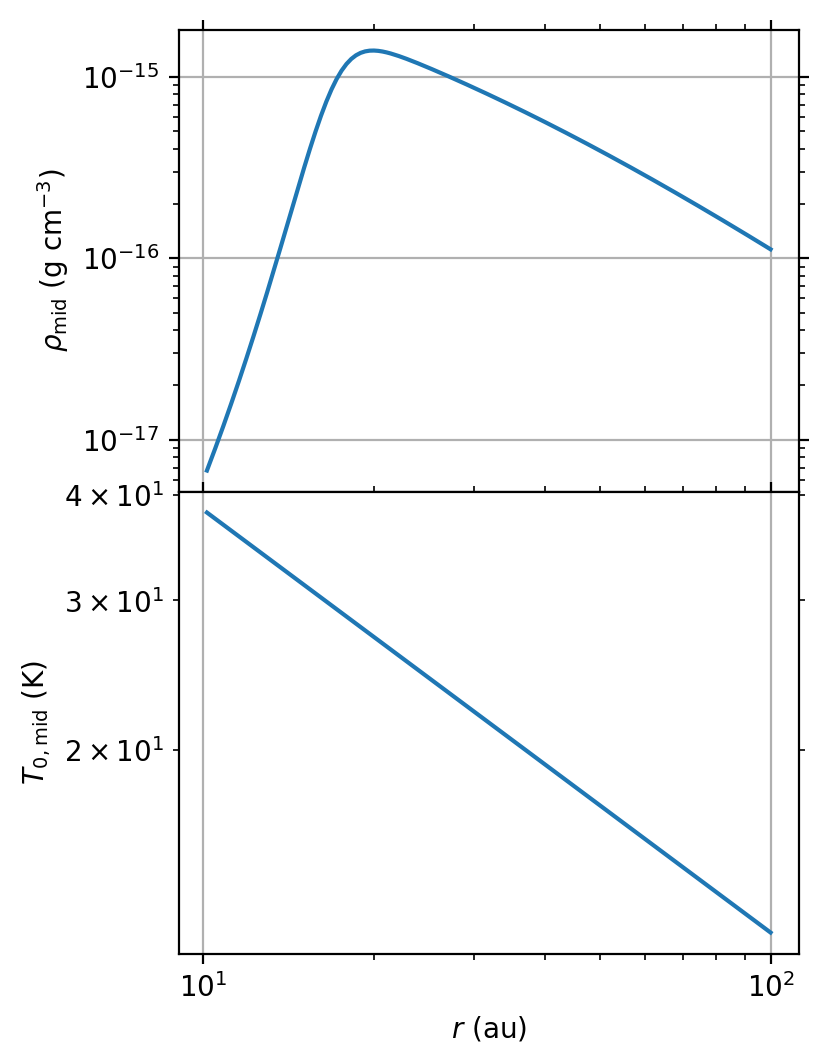

In [6]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# BEGIN [pgen].cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = np.abs(x1*np.sin(x2))
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(rad, phi, z):
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCylOrig(rad, phi, z):
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power(rad/r0, dslope)
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# END [pgen].cpp

# extra quantities
kappa_star_cgs    = 10                 # [cm^2/g]
dgratio           = 100                # dust-to-gas ratio
small_grain_ratio = 0.02184

# Solar constants, astrophysical units and conversions
Lsun             = 3.83e33             # solar luminosity [erg/s]
Rsun             = 6.95700e10          # solar radius [cm]
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]

# begin athinput.[pgen]
# <mesh>
nx1              = 256                 # Number of zones in X1-direction
x1min            = 0.250163663377926   # minimum value of X1
x1max            = 2.501636633779264   # maximum value of X1

nx2              = 1024                # Number of zones in X2-direction
x2min            = 0                   # minimum value of X2
x2max            = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor           = 1e-12               # minimum density

# <radiation>
T_unit           = 6.14e3              # T_0 [K]
density_unit     = 4.28e-14            # \rho_0 [g/cm^3]
length_unit      = 5.98e14             # L_0 [cm]
molecular_weight = 0.6                 # \mu

# <problem>
r0               = 0.425278227742474   # disk radial normalization [L_0]
rho0             = 0.2                 # disk density normalization [\rho_0]
p0_over_r0       = 4.80e-03            # (H/r0)^2
pslope           = -0.5                # pressure power-law index
dslope           = -2.25               # density power-law index
kappa_a          = 102327.36834165471  # Planck mean absorption opacity [\rho_0*L_0]
# end athinput.[pgen]

# Conversions
def r2au(r):
  return r*L_au
def rho2cgs(rho):
  return rho*density_unit
def T2cgs(T):
  return T*T_unit
def mass2cgs(mass):
  return mass*density_unit*length_unit**3
def g2solar_mass(g):
  return g/1.988416e33
rad2deg          = 180/np.pi           # [deg]

# Compute dust opacity in code units
kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'h/r (r = L_0) = {(PoverR(1, np.pi/2, 0))**0.5:.2f}'\
      + f' (cf. original h/r_0 = {p0_over_r0**0.5:.2f})\n')
print('/athinput.[pgen]\n<problem>\n...')
print(rf'kappa_a = {kappa_a:.11f}  # absorption opacity [1/(\rho_0*L_0)]')
print(rf'kappa_a = {kappa_a/density_unit/length_unit:.2e} cm^2/g')

# Convert and print disk masses
print(f'r_0 = {r2au(r0):.2f} au')
print(f'rho_0 = {rho2cgs(rho0):.2e} g')
print(f'P_0/rho_0 = {T2cgs(p0_over_r0):.2f} K')
m_gas = g2solar_mass(mass2cgs(2.46155))
m_dust = g2solar_mass(mass2cgs(2.83015e-02))
print(f'M_gas = {m_gas:.2e} M_sun')
print(f'M_dust = {m_dust:.2e} M_sun')

# Generate fields
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rads, phis, zs = GetCylCoord(x1mesh, x2mesh, 0)
rho_field_theo = DenProfileCyl(rads, phis, zs)
rho_field_theo[rho_field_theo < dfloor] = dfloor
rho_field_theo_orig = DenProfileCylOrig(rads, phis, zs)
rho_field_theo_orig[rho_field_theo_orig < dfloor] = dfloor
T_field_theo = PoverR(rads, phis, zs)
dtheta_theo = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta_theo)

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=200)
axs[0].plot(x1v*L_au, rho2cgs(rho_field_theo[j_mid, :]), 'tab:blue',)
axs[1].plot(x1v*L_au, T_field_theo[j_mid, :]*T_unit, 'tab:blue')

# Format subplots
for ax in axs:
  ax.set(xscale='log', yscale='log')
  ax.grid()
  ax.minorticks_on()
  ax.tick_params(axis='both', which='both', top=True, right=True)

# axs[0].legend()
axs[0].set(ylabel=r'$\rho_\mathrm{mid}$ (g cm$^{-3}$)')
axs[0].tick_params(axis='both', which='both', top=True, right=True)
axs[1].set(xlabel=r'$r$ (au)',
           ylabel=r'$T_{0,\mathrm{mid}}$ (K)')
plt.subplots_adjust(hspace=0.0)
plt.savefig('figs/midplane.pdf', bbox_inches='tight', pad_inches=0.01)

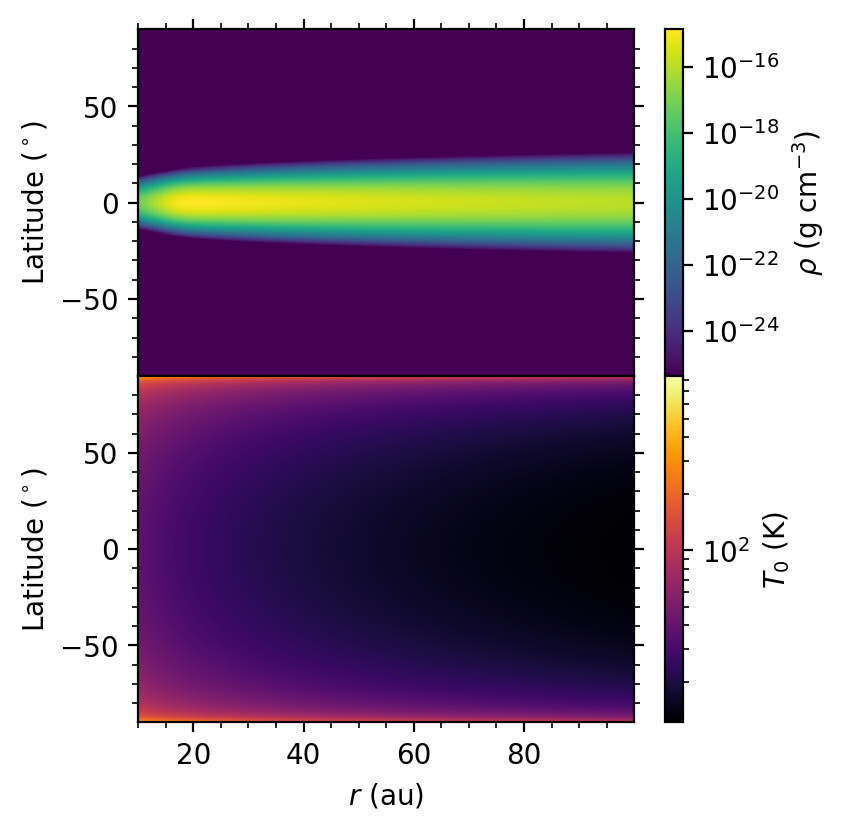

In [7]:
#===============================================================================
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

problem_id = 'dsharp'
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 4.5), dpi=200)

# Contour labels
def fmt(x):
  return rf'$\tau_f={x:.0f}$'

# Conversions
rad2deg = 180/np.pi      # [deg]

# Read and plot
path = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'\
       +f'/dsharp_abs-sca/nfreq/3/v2'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
T_unit = athinput['radiation']['T_unit']
N_f = 1
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00000.athdf')
t = athdf['Time']
# Density field
im0 = axs[0].pcolormesh(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg,
                        athdf['rho'][0]*density_unit, cmap='viridis',
                        norm=colors.LogNorm())
# Temperature field
T_field = athdf['press'][0]/athdf['rho'][0]
im1 = axs[1].pcolormesh(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg,
                        T_field*T_unit, cmap='inferno',
                        norm=colors.LogNorm())

# Constants
arad = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
au      = 1.495978707e13 # astronomical unit [cm]
L_au    = length_unit/au # [au]

# Format secondary (colorbar) scales in cgs
def r2au(r):
  return r*L_au

def F2cgs(F):
  return F*c_speed*arad*T_unit**4 # arad = 4 * sigma/c

def r2au(r):
  return r*L_au

def T2cgs(T):
  return T*T_unit

# ax_r = axs[0].secondary_xaxis('top', functions=(r2au, r2au))
# ax_r.set(xlabel=r'$r$ (au)')
# ax_r.minorticks_on()
cbar_F = plt.colorbar(im0, label=r'$\rho$ (g cm$^{-3}$)')
# cbar_F_cgs = cbar_F.ax.secondary_yaxis('left', functions=(F2cgs, F2cgs))
# cbar_F_cgs.set(ylabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}$ (erg s$^{-1}$ cm$^{-2}$)')
cbar_T = plt.colorbar(im1, label=r'$T_0$ (K)')
# cbar_T_K = cbar_T.ax.secondary_yaxis('left', functions=(T2cgs, T2cgs))
# cbar_T_K.set(ylabel=r'$T$ (K)')

# Format (sub)plots
for i, ax in enumerate(axs):
  # ax.invert_yaxis()
  ax.minorticks_on()
  ax.set(ylabel=r'Latitude ($^\circ$)')
  ax.tick_params(axis='both', which='both', right=True)

plt.subplots_adjust(hspace=0)
axs[0].tick_params(axis='both', which='both', top=True)
axs[1].set(xlabel=r'$r$ (au)')
plt.savefig('figs/disk.png', dpi=600, bbox_inches='tight', pad_inches=0.01)

## Thermal Equilibrium

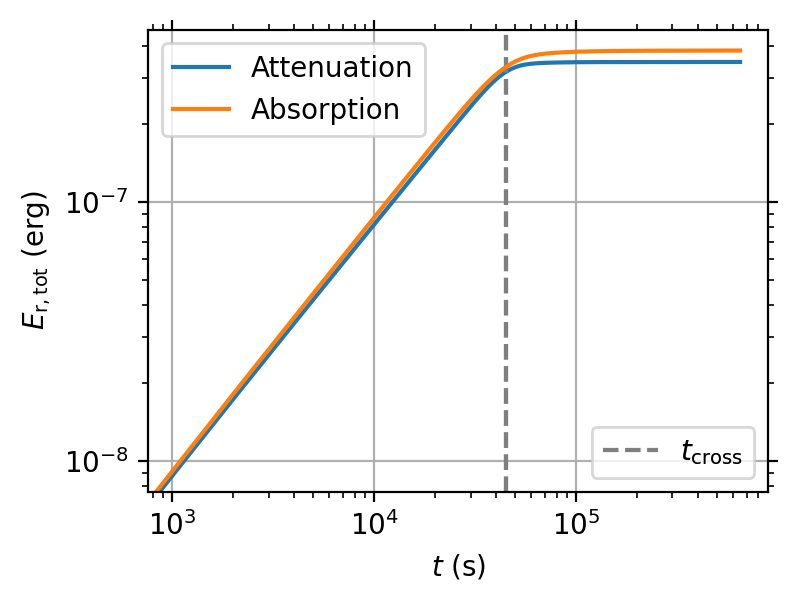

In [8]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
def t2s(t):
    return t*length_unit/cs_iso
def E2erg(E):
    return E*arad*T_unit**4
def T2cgs(T):
  return T*T_unit

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['dashdot', 'dashed', 'dotted', (0, (1, 5))]
c_solns, ref_soln = [], []
crat = None
theta = None

# Read and plot
problem_id = 'dsharp'
root = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'\
       +'/dsharp_abs-sca'
base = 'nfreq'
runs = [['64-no_heat', 'Attenuation'],
        # ['../../dsharp_abs-nonRTE/nfreq/64', 'Absorption*'],
        ['64', 'Absorption'],]
for i, run in enumerate(runs):
    path = f'{root}/{base}/{run[0]}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    reduced_factor = athinput['radiation']['reduced_factor']
    length_unit = athinput['radiation']['length_unit']
    molecular_weight = athinput['radiation']['molecular_weight']
    arad = 7.565733250033928e-15
    r_ideal = 8.314462618e7/molecular_weight
    T_unit = athinput['radiation']['T_unit']
    cs_iso = (r_ideal*T_unit)**0.5
    Vmax = 4/3*np.pi*athinput['mesh']['x1max']**3
    Vmin = 4/3*np.pi*athinput['mesh']['x1min']**3
    Vtot = (Vmax - Vmin)/2
    gamma = athinput['hydro']['gamma'] # C_p/C_v = 1 + 2/DoF
    hst = athena_read.hst(f'{path}/output/{problem_id}.hst')
    T_tot = hst['tot-E']*(gamma - 1)*Vtot/hst['mass']
    # Compute light crossing time for oblique beams
    Lx = athinput['mesh']['x1max'] - athinput['mesh']['x1min']
    with open(f'{path}/output/Rad_angles.txt') as Rad_angles:
        lines = Rad_angles.read().splitlines()
        crat = float(lines[2].split()[1])
        mu = '32   1.000000e+00   0.000000e+00   0.000000e+00    2.941176e-02'
        mu_x, mu_y = float(mu.split()[1]), float(mu.split()[2])
        theta = np.arctan(mu_y/mu_x)
    t_cross = Lx/np.cos(theta)/crat
    ax.axvline(t2s(t_cross*reduced_factor), color='tab:gray', ls='dashed')
    Er = hst['Er']
    if 'n_frequency' in athinput['radiation']:
        nfreq = athinput['radiation']['n_frequency']
        Er = Er.reshape(-1, nfreq)
        Er = Er.sum(axis=1)
    t_adj = hst['time']*reduced_factor
    c_solns.append(ax.plot(t2s(t_adj), E2erg(Er), tab_colors[i],
                   label=f'{run[1]}')[0])

# Plot ghost point(s) for colorless linestyles
ref_soln.append(ax.plot([], [], 'tab:gray', ls='dashed',
                label=r'$t_\mathrm{cross}$')[0])
ax.add_artist(plt.legend(handles=c_solns, loc='upper left'))
ax.add_artist(plt.legend(framealpha=0.56, handles=ref_soln, loc='lower right'))

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.set(xlabel=r'$t$ (s)', ylabel=r'$E_\mathrm{r,tot}$ (erg)', xscale='log',
       yscale='log')
plt.savefig('figs/evolution.pdf', bbox_inches='tight', pad_inches=0.01)

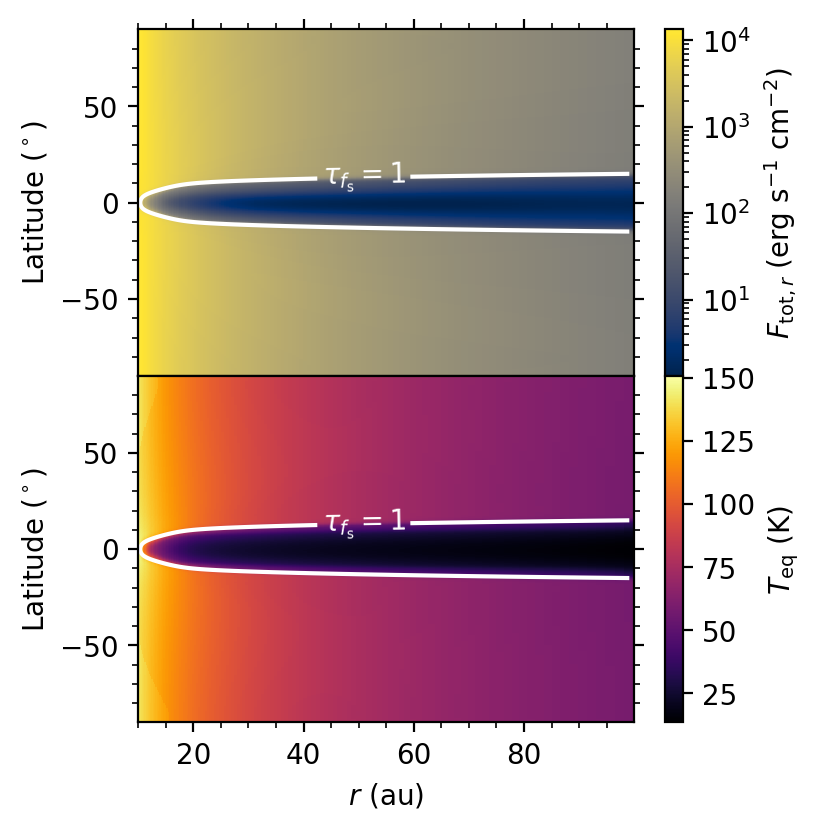

In [9]:
#===============================================================================
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

problem_id = 'dsharp'
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 4.5), dpi=200)

# Contour labels
def fmt(x):
  return rf'$\tau_{{f_\mathrm{{s}}}}={x:.0f}$'

# Conversions
rad2deg = 180/np.pi      # [deg]

# Constants
arad = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
au      = 1.495978707e13 # astronomical unit [cm]
L_au    = length_unit/au # [au]

# Read and plot
root = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'\
       +'/dsharp_abs-sca'
path = f'{root}/nfreq/64'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
L_au    = length_unit/au # [au]
T_unit = athinput['radiation']['T_unit']
N_f = 1
f_star = 54
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
t = athdf['Time']
# Radial flux field
Fx_field = np.zeros_like(athdf['rho'][0])
try:
  N_f = athinput['radiation']['n_frequency']
  dtau = (athdf[f'Sigma_a_{f_star}'][0] + athdf[f'Sigma_s_{f_star}'][0])\
         *np.diff(athdf['x1f'])
  for f in range(N_f):
    key = f'Fr_{f}_1'
    Fx_field += athdf[key][0]
except KeyError:
  dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
  Fx_field = athdf['Fr1'][0]
im0 = axs[0].pcolormesh(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg,
                        Fx_field*c_speed*arad*T_unit**4, cmap='cividis',
                        norm=colors.LogNorm())
# Temperature field
T_field = athdf['press'][0]/athdf['rho'][0]
im1 = axs[1].pcolormesh(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg,
                        T_field*T_unit, cmap='inferno')#, norm=colors.LogNorm())
# tau = 1 surface
tau_field = np.cumsum(dtau, axis=1)

cbar_F = plt.colorbar(im0, label=r'$F_{\mathrm{tot},r}$ (erg s$^{-1}$ cm$^{-2}$)')
cbar_T = plt.colorbar(im1, label=r'$T_\mathrm{eq}$ (K)')

# Format (sub)plots
for i, ax in enumerate(axs):
  CS = ax.contour(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg, tau_field, [1, 1e5],
                  colors=['white', 'white'])
  ax.clabel(CS, CS.levels, fmt=fmt)
  ax.minorticks_on()
  ax.set(ylabel=r'Latitude ($^\circ$)')
  ax.tick_params(axis='both', which='both', right=True)

plt.subplots_adjust(hspace=0)
# axs[0].set(title=rf'Athena++ ($N_f={N_f}$)')
axs[0].tick_params(axis='both', which='both', top=True)
axs[1].set(xlabel=r'$r$ (au)')
plt.savefig('figs/thermal_equilibrium.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

# Comparisons

## Gray Opacity

### Attenuation

#### Optical Depth, Specific Intensity, Radial Flux

From Rybicki & Lightman (1979), we define the *optical depth* along a ray in the radial direction $r$ at polar angle $\theta$ as
\begin{align*}
  \mathrm{d}\tau &\equiv \alpha\mathrm{d}r \\
  \tau(r, \theta) &= \int_{r_0}^r \alpha(r', \theta)\mathrm{d}r', \tag{1.26}
\end{align*}
where we define the *absorption coefficient* $[\mathsf{L}^{-1}]$ as
$$
\alpha(r, \theta) \equiv \rho\kappa_\mathrm{a},
\tag{1.22}
$$
for mass density $\rho(r, \theta)$ and *opacity* coefficient $\kappa_\mathrm{a}$ $[\mathsf{L}^2\mathsf{M}^{-1}]$.
With these, we can express the radiative transfer equation (1.23)—for absorption only—in terms of the optical depth as
$$
  \frac{\mathrm{d}I}{\mathrm{d}\tau} = -I
$$
with the solution
$$
  I(\tau) = I(0)e^{-\tau}.
$$
For *blackbody radiation* from a surface of uniform brightness $B$ at temperature $T$ (Rybicki & Lightman 1979, eq. 1.42)
$$
  I(0) = B(T) = \frac{a_\mathrm{r}c}{4\pi}T^4.
$$
The flux $F$ at a radial distance $r$ from a sphere of uniform brightness $B$ and with radius $R$ is (cf. Rybicki & lightman 1979, eq. 1.13)
\begin{align*}
  F &= \pi B\left(\frac{R}{r}\right)^2e^{-\tau} \\
    &= \frac{ca_\mathrm{r}T^4}{4}\left(\frac{R}{r}\right)^2e^{-\tau}.
\end{align*}

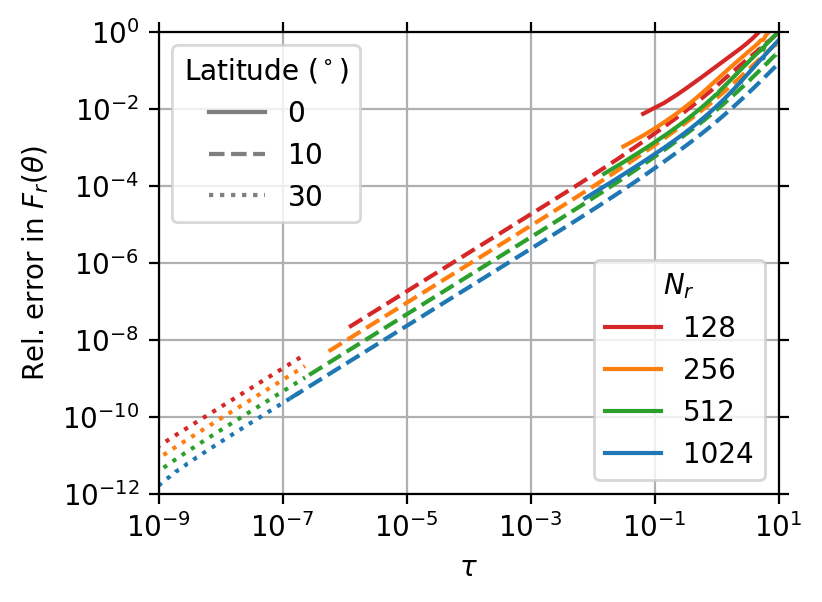

In [10]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# Athena++
problem_id = 'dsharp'
base = 'nfreq/1/log-nx1'
runs = ['128', '256', '512', '1024']
for i, run in enumerate(runs):
    path = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'\
           +f'/dsharp_abs-sca/{base}/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    nx1 = athinput['mesh']['nx1']
    nx2 = athinput['mesh']['nx2']
    length_unit = athinput['radiation']['length_unit']
    r_star = athinput['problem']['r_star']
    t_star = athinput['problem']['t_star']
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
            /athinput['mesh']['nx2']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
    tau = np.cumsum(dtau, axis=1)
    Fx_min = 1e-14
    Fx_field = np.clip(athdf['Fr1'][0], Fx_min, None)
    Fx_theo = np.power(t_star, 4)*np.power(r_star/athdf['x1v'], 2)\
              /4*(np.exp(-tau))
    Fx_theo = np.clip(Fx_theo, Fx_min, None)
    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        rel_err_Fx = (Fx_field[j, :] - Fx_theo[j,:])/Fx_theo[j,:]
        ax.plot(tau[j, :], rel_err_Fx, color=tab_colors[i], ls=lss[th])
        if i == 0:
            ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                            label=rf'${90-theta_deg}$')[0])
    c_solns.append(ax.plot([], [], tab_colors[i], label=f'{run}')[0])

# Plot ghost points for colorless line style and add legends
ax.add_artist(plt.legend(title=r'$N_r$', handles=c_solns, loc='lower right'))
ax.add_artist(ax.legend(framealpha=0.56, handles=ls_thetas, loc='upper left',
                        title=r'Latitude ($^\circ)$'))

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$\tau$', xscale='log', xlim=(1e-9, 1e1),
       ylabel=r'Rel. error in $F_r(\theta)$', yscale='log', ylim=(1e-12, 1))
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig('figs/attenuation.pdf', bbox_inches='tight', pad_inches=0.01)

### Absorption

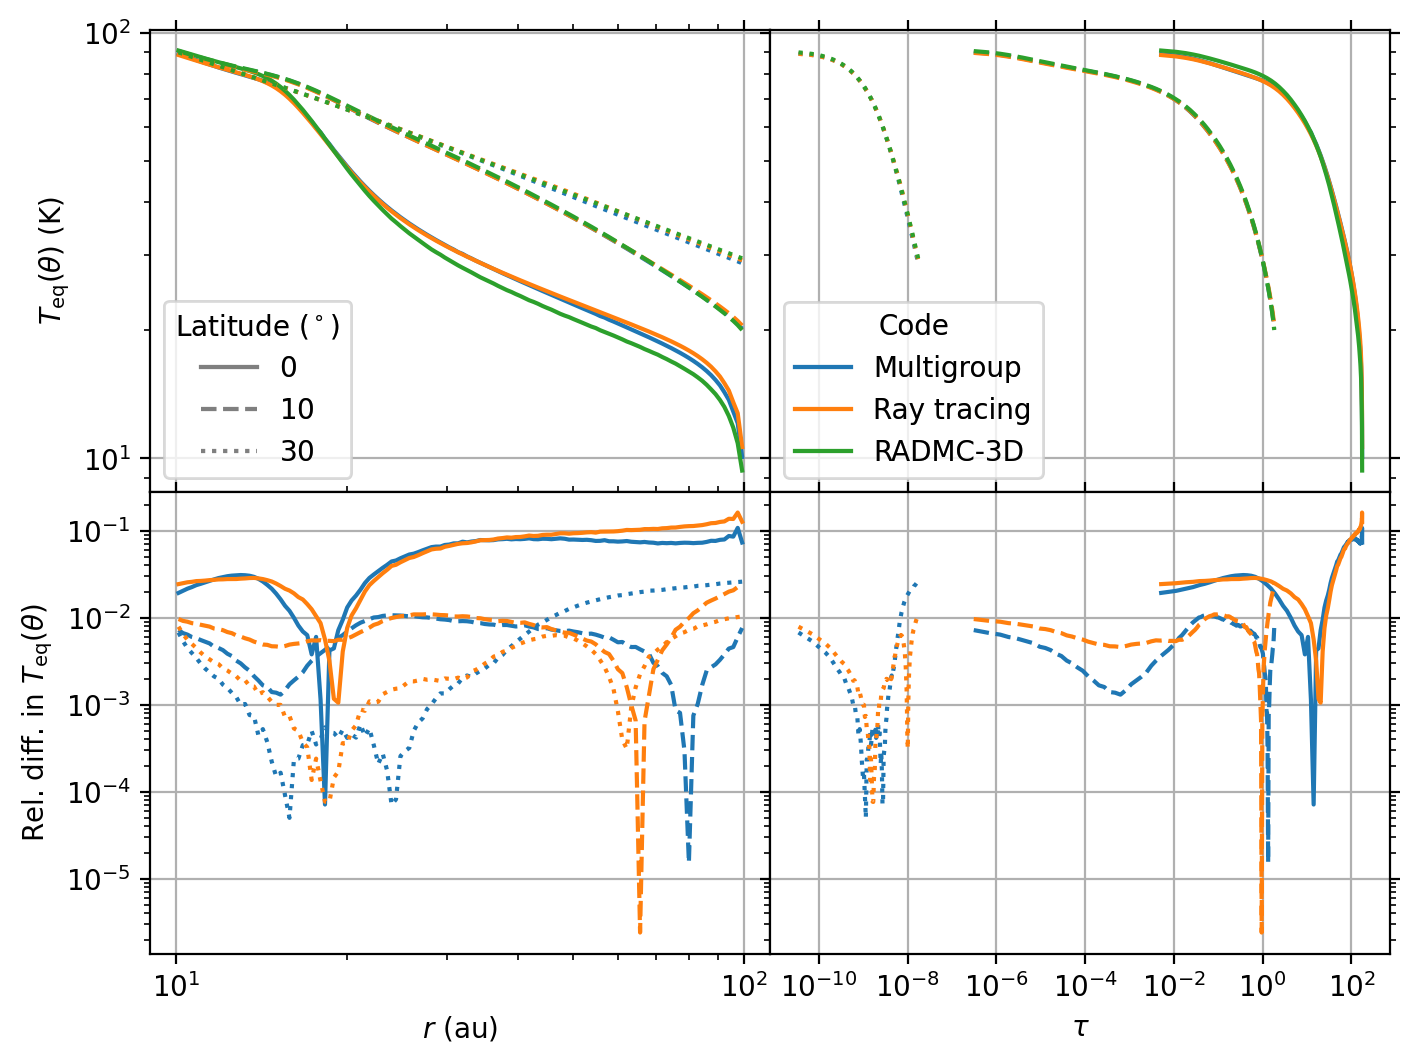

In [11]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'constopac'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)

# Athena++
problem_id = ['dsharp', 'disk']
output = ['00001', '00100']
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'dsharp_abs-sca/zhang24comp'
runs = ['sab/constopac', 'sz/constopac_updated']
code = ['Multigroup', 'Ray tracing']
for i, run in enumerate(runs):
  path = f'{base}/{run}'
  if i == 0:
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}')
    length_unit = athinput['radiation']['length_unit']
    T_unit = athinput['radiation']['T_unit']
  else:
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}_sph_rad')
    length_unit = athinput['radiation']['lunit']
    T_unit = athinput['radiation']['Tunit']
  nx1 = athinput['mesh']['nx1']
  nx2 = athinput['mesh']['nx2']
  nzeta = athinput['radiation']['nzeta']
  L_au = length_unit/au
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id[i]}.out1.{output[i]}.athdf')
  dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
  tau = np.cumsum(dtau, axis=1)
  T_field = athdf['press'][0]/athdf['rho'][0]
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                 /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit, color=tab_colors[i],
                ls=lss[th])
    axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color=tab_colors[i],
                   ls=lss[th])
    axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color=tab_colors[i],
                   ls=lss[th])
    axs[1][1].plot(tau[j, :], rel_diff_T, color=tab_colors[i], ls=lss[th])
    if i == 1:
      ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                       label=rf'${90-theta_deg}$')[0])
      axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color=tab_colors[i+1],
                     ls=lss[th])
      axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color=tab_colors[i+1],
                     ls=lss[th])
  c_solns.append(axs[1][1].plot([], [], color=tab_colors[i],
                 label=f'{code[i]}')[0])
c_solns.append(axs[1][1].plot([], [], color=tab_colors[i+1],
               label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][0].add_artist(axs[0][0].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      title=r'Code'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)', ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau$')
# fig.suptitle(r'$\kappa_{\nu,f}^\mathrm{abs+sca}$', y=0.92)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/gray_absorption.pdf', bbox_inches='tight', pad_inches=0.01)

## Multifrequency Opacities

### Absorption

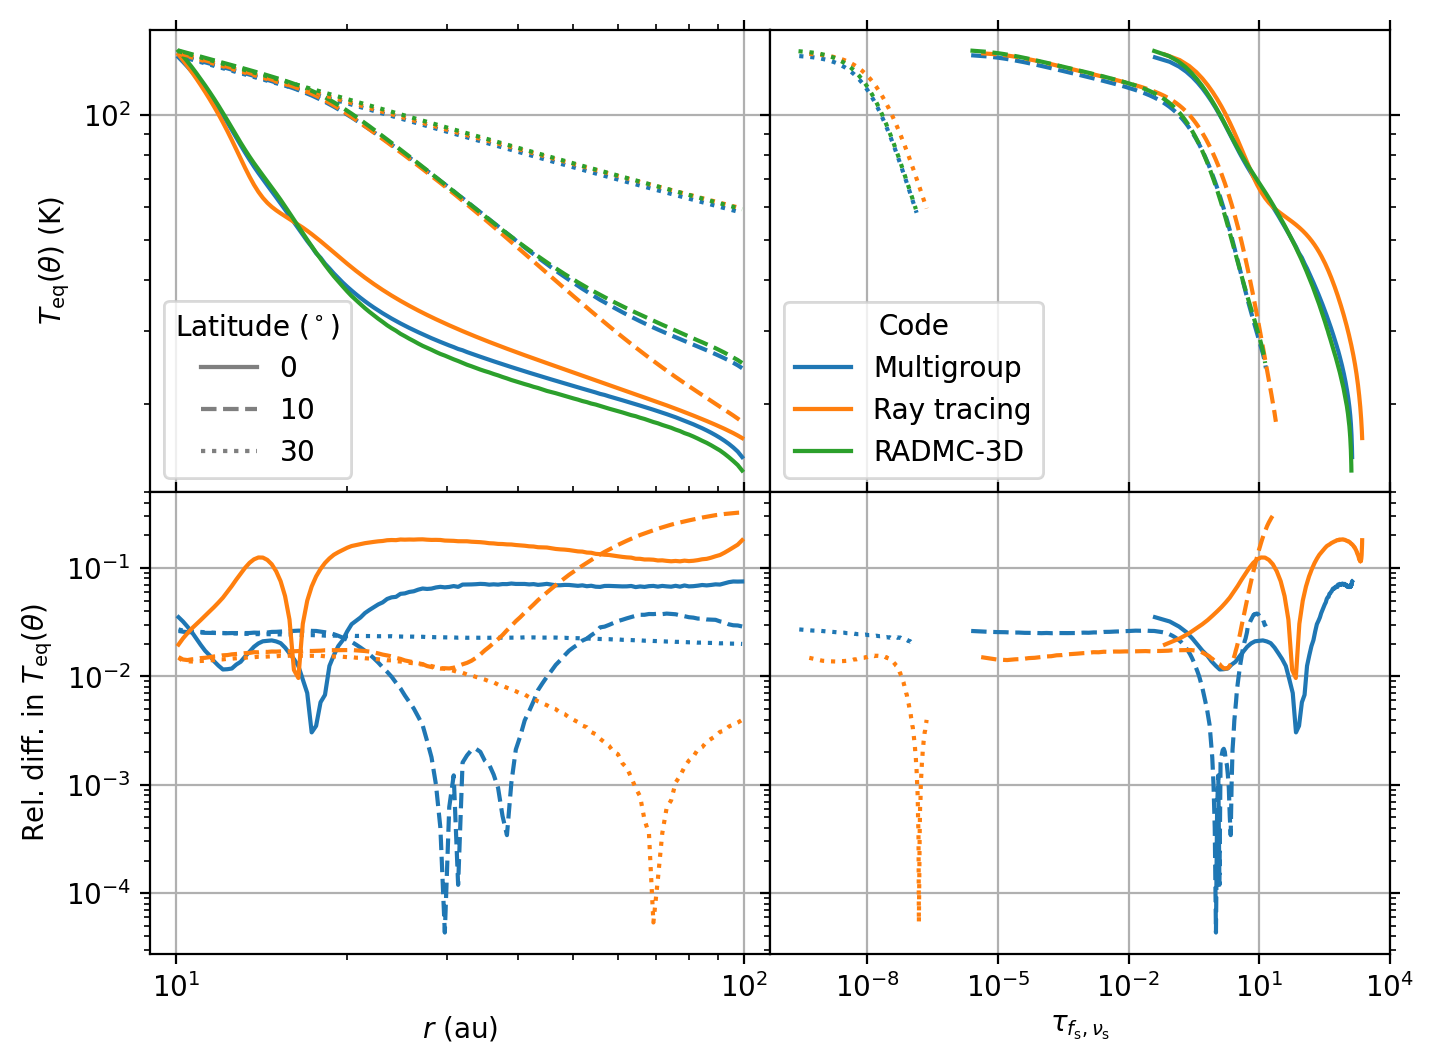

In [12]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)

# Athena++
problem_id = ['dsharp', 'disk']
output = ['00001', '00100']
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'
runs = ['dsharp_abs-nonRTE/nfreq/64',
        'dsharp_abs-sca/zhang24comp/sz/hybrid_updated']
code = ['Multigroup', 'Ray tracing']
for i, run in enumerate(runs):
  path = f'{base}/{run}'
  if i == 0:
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}')
    length_unit = athinput['radiation']['length_unit']
    T_unit = athinput['radiation']['T_unit']
  else:
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}_sph_rad')
    rhounit = athinput['radiation']['rhounit']
    T_unit = athinput['radiation']['Tunit']
    length_unit = athinput['radiation']['lunit']
    kappa_star = athinput['radiation']['kappa_star']
  nx1 = athinput['mesh']['nx1']
  nx2 = athinput['mesh']['nx2']
  L_au = length_unit/au
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id[i]}.out1.{output[i]}.athdf')
  if problem_id[i] == 'dsharp':
    f_star = 54
    dtau = athdf[f'Sigma_a_{f_star}'][0]*np.diff(athdf['x1f'])
  else:
    dtau = kappa_star*rhounit*length_unit*athdf['rho'][0]*np.diff(athdf['x1f'])
  tau = np.cumsum(dtau, axis=1)
  T_field = athdf['press'][0]/athdf['rho'][0]
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                 /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit, color=tab_colors[i],
                ls=lss[th])
    axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color=tab_colors[i],
                   ls=lss[th])
    axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color=tab_colors[i],
                   ls=lss[th])
    axs[1][1].plot(tau[j, :], rel_diff_T, color=tab_colors[i], ls=lss[th])
    if i == 1:
      ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                       label=rf'${90-theta_deg}$')[0])
      axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color=tab_colors[i+1],
                     ls=lss[th])
      axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color=tab_colors[i+1],
                     ls=lss[th])
  c_solns.append(axs[1][1].plot([], [], color=tab_colors[i],
                 label=f'{code[i]}')[0])
c_solns.append(axs[1][1].plot([], [], color=tab_colors[i+1],
               label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][0].add_artist(axs[0][0].legend(framealpha=0.56, handles=ls_thetas, 
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      title=r'Code'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)', ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_{f_\mathrm{s},\nu_\mathrm{s}}$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/multifrequency_absorption.pdf', bbox_inches='tight', pad_inches=0.01)

### Scattering

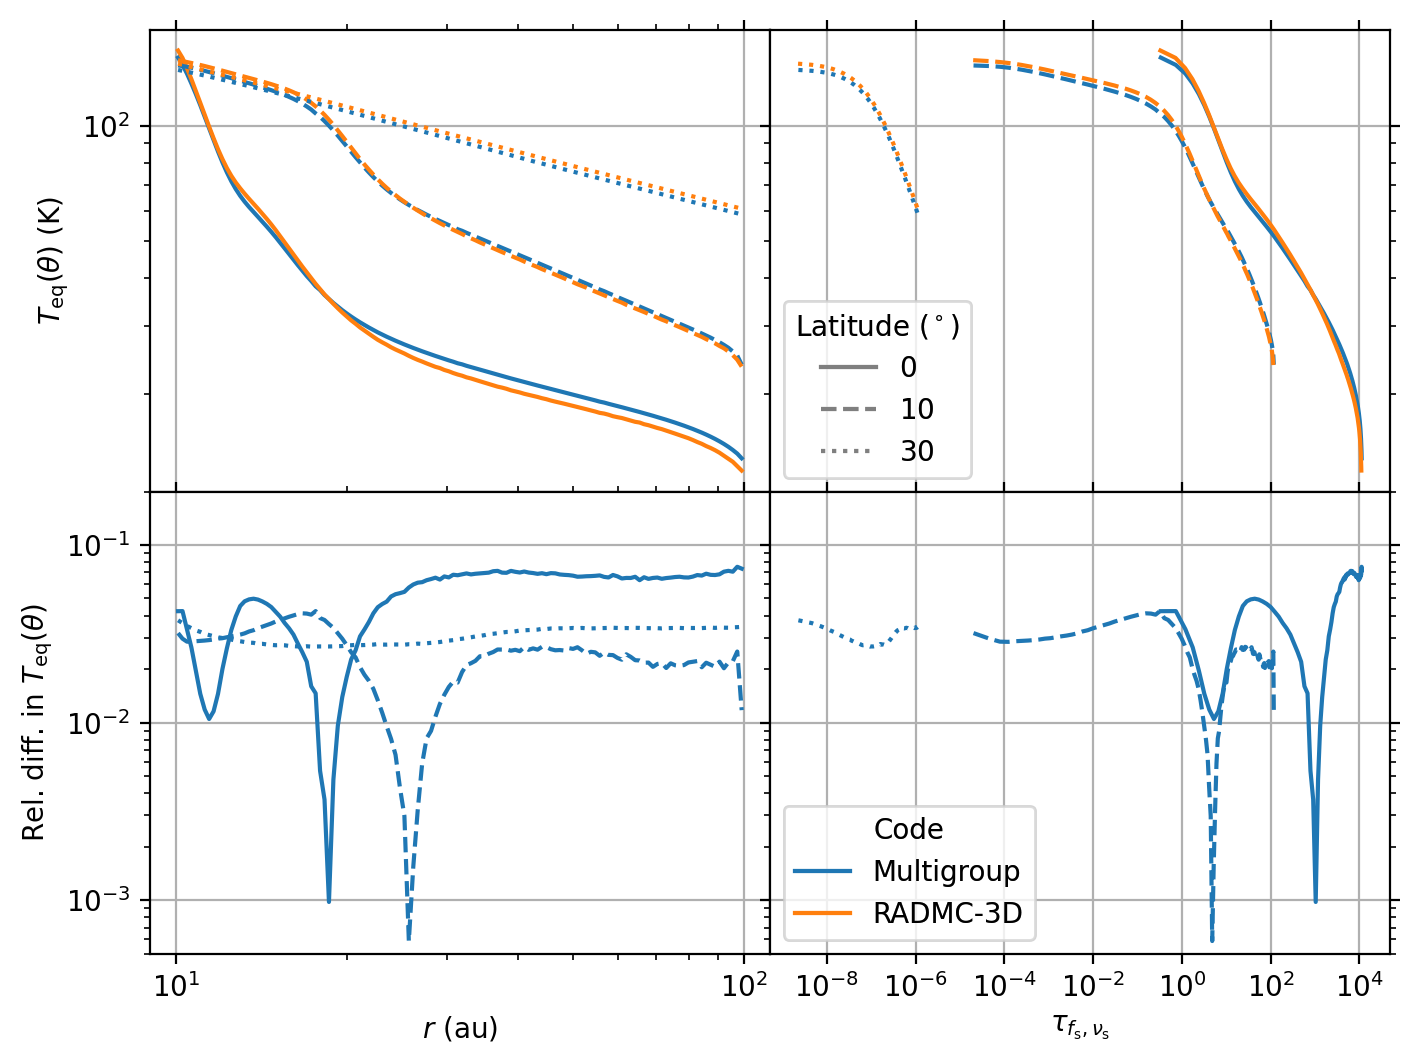

In [13]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs-sca'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-sca/nfreq'
run = '64'
f_star = 54
path = f'{base}/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
nx1 = athinput['mesh']['nx1']
nx2 = athinput['mesh']['nx2']
nzeta = athinput['radiation']['nzeta']
nfreq = athinput['radiation']['n_frequency']
length_unit = athinput['radiation']['length_unit']
T_unit = athinput['radiation']['T_unit']
L_au = length_unit/au
dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
         /athinput['mesh']['nx2']
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
dtau = (athdf[f'Sigma_a_{f_star}'][0] + athdf[f'Sigma_s_{f_star}'][0])\
       *np.diff(athdf['x1f'])
tau = np.cumsum(dtau, axis=1)
T_field = athdf['press'][0]/athdf['rho'][0]
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                    /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit, color='tab:blue',
                ls=lss[th])
    axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color='tab:orange', ls=lss[th])
    axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color='tab:blue',
                   ls=lss[th])
    axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color='tab:orange',
                   ls=lss[th])
    axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color='tab:blue',
                   ls=lss[th])
    axs[1][1].plot(tau[j, :], rel_diff_T, color='tab:blue', ls=lss[th])
    ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                 label=rf'${90-theta_deg}$')[0])
c_solns.append(axs[1][1].plot([], [], color='tab:blue', label=f'Multigroup')[0])
c_solns.append(axs[1][1].plot([], [], color='tab:orange', label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[1][1].add_artist(axs[1][1].legend(framealpha=0.56, handles=c_solns,
                                      title=r'Code'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)', ylim=(5e-4, 2e-1),
          
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_{f_\mathrm{s},\nu_\mathrm{s}}$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/scattering.pdf', bbox_inches='tight', pad_inches=0.01)

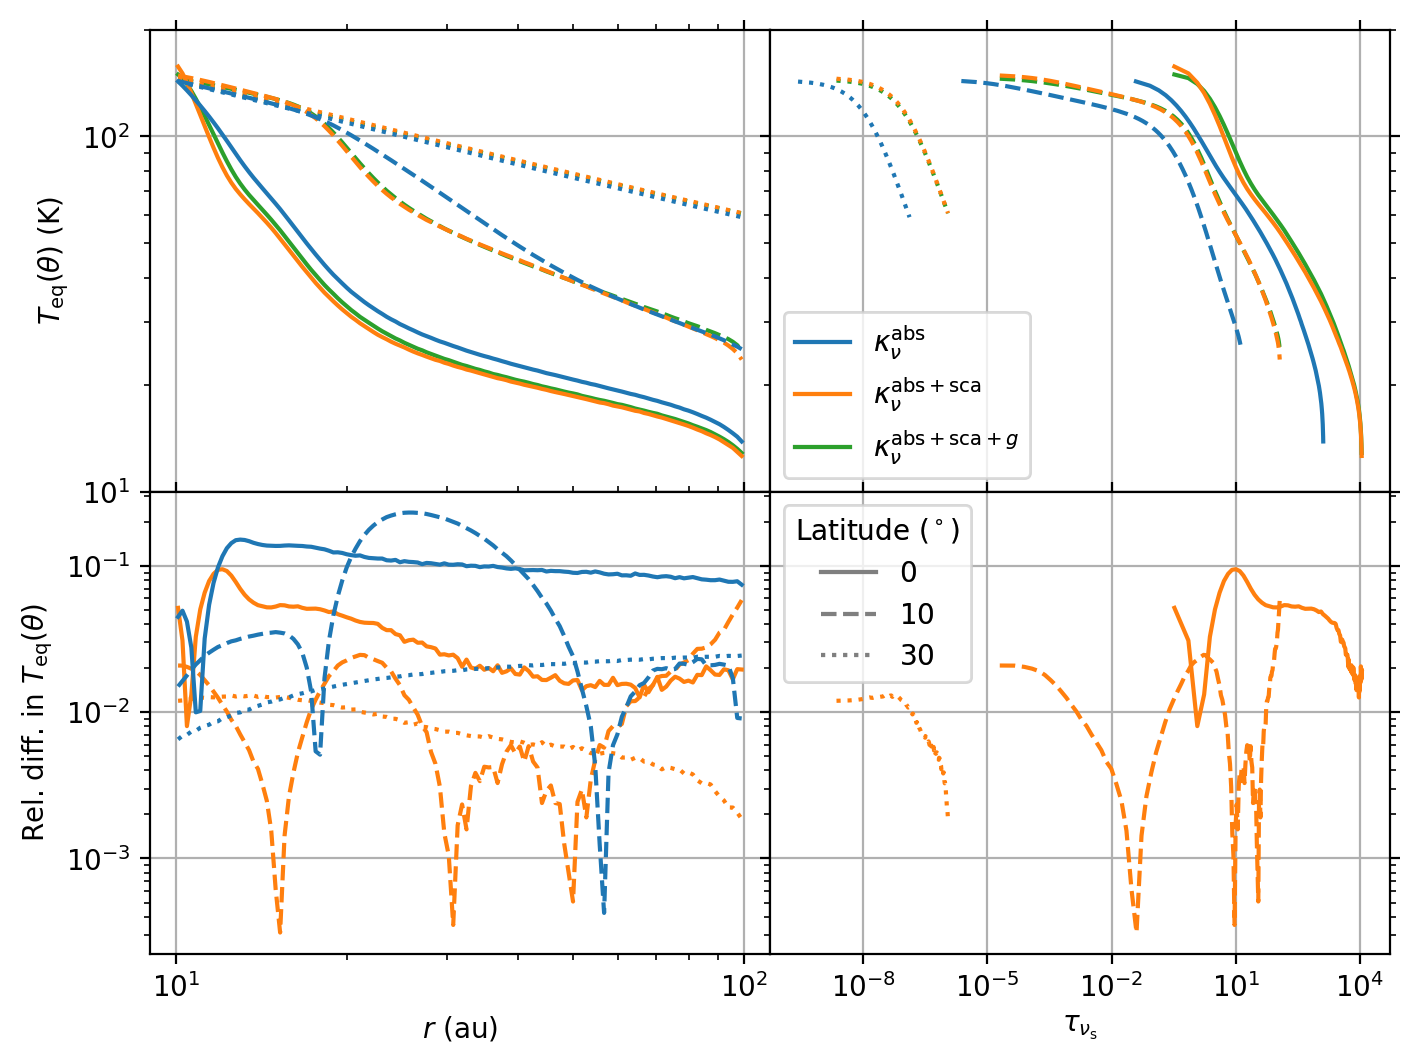

In [14]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
runs = [['dsharp_abs-sca-g', 'tab:green'],
        ['dsharp_abs-sca', 'tab:orange'],
        ['dsharp_abs', 'tab:blue']]
for i, run in enumerate(runs):
  path = f'{base}/{run[0]}'
  grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
  taux = np.load(f'{path}/taux.npz')['taux']
  dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
  dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color=run[1],
                   ls=lss[th])
    axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color=run[1],
                   ls=lss[th])
    if i == 0:
      ref_temp = dusttemp
      ls_thetas.append(axs[1][1].plot([], [], color='tab:gray', ls=lss[th],
                       label=rf'${90-theta_deg}$')[0])
    else:
      rel_diff_T = 2*np.abs(ref_temp[:,j,0,0] - dusttemp[:,j,0,0])\
                   /(ref_temp[:,j,0,0] + dusttemp[:,j,0,0])
      axs[1][0].plot(grid.x/au, rel_diff_T, color=run[1], ls=lss[th])
      if i == 1:
        axs[1][1].plot(taux[:,j,0], rel_diff_T, color=run[1], ls=lss[th])

# Multiple legends
c_solns.append(axs[0][1].plot([], [], color='tab:blue',
               label=r'$\kappa_\nu^\mathrm{abs}$')[0])
c_solns.append(axs[0][1].plot([], [], color='tab:orange',
               label=r'$\kappa_\nu^\mathrm{abs+sca}$')[0])
c_solns.append(axs[0][1].plot([], [], color='tab:green',
               label=r'$\kappa_\nu^{\mathrm{abs+sca}+g}$')[0])
axs[1][1].add_artist(axs[1][1].legend(framealpha=0.56, handles=ls_thetas,
                                      loc='upper left',
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      loc='lower left'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)', ylim = (10, 2e2))
axs[1][0].set(xlabel=r'$r$ (au)', ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_{\nu_\mathrm{s}}$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/scattering_modes.pdf', bbox_inches='tight', pad_inches=0.01)

## Optimization

ν_peak(T_s) = 3.40e+14 Hz = 0.88 μm


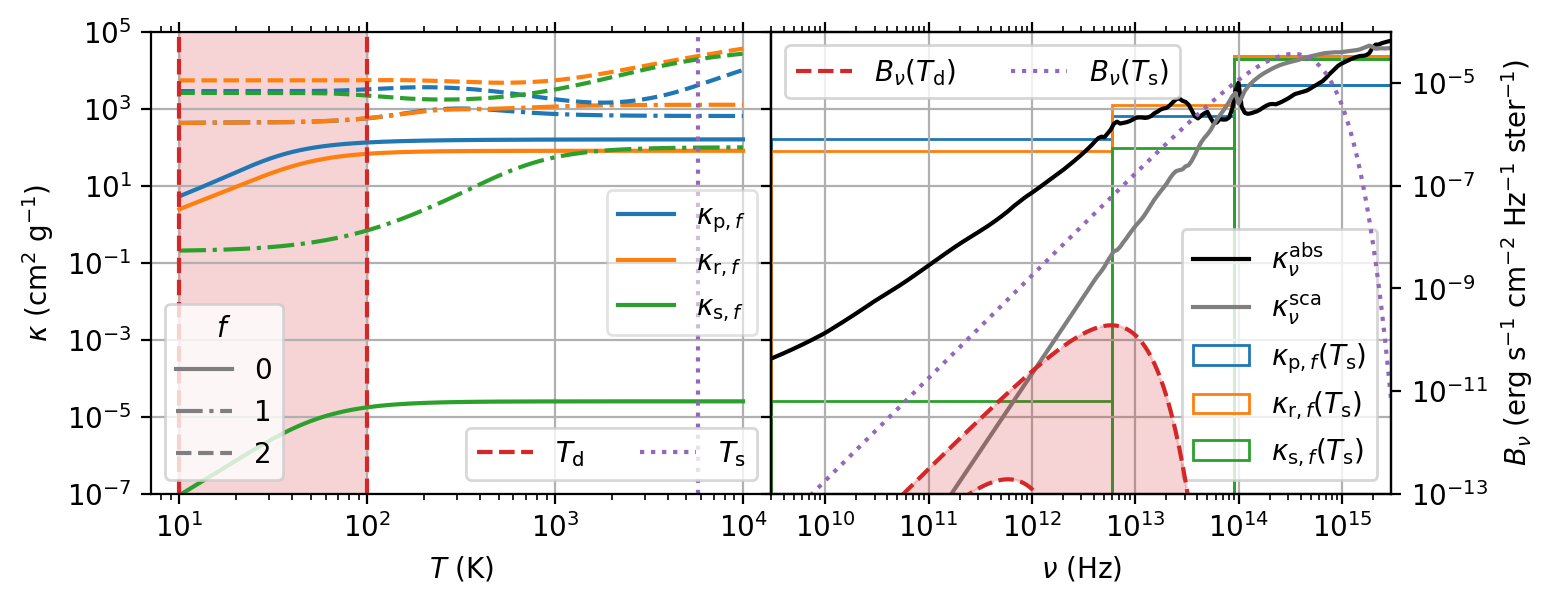

In [23]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import warnings

# Path
problem_id = 'dsharp'
base = 'nfreq'
ver = '3/v2'
path = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'\
       +f'/dsharp_abs-sca/{base}/{ver}'

# Make tables to compute and save mean opacities
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
T_unit = athinput['radiation']['T_unit']                           # [K]
density_unit = athinput['radiation']['density_unit']               # [g/cm^3]
length_unit = athinput['radiation']['length_unit']                 # [cm]
ntemp = athinput['problem']['n_temperature']
temperature_min = athinput['problem']['temperature_min']           # [K]
temperature_max = athinput['problem']['temperature_max']           # [K]
temp_table = np.logspace(np.log10(temperature_min), np.log10(temperature_max),
                         ntemp)
Bnu_table = GetBnu_table(temp_table, opac_freq)
dBnu_dT_table = GetdBnu_dT_table(temp_table, opac_freq)

# For a single or multiple frequency bands
nu_min, nu_max = opac_freq[0], opac_freq[-1]
xlim = (nu_min, nu_max)
nfreq = athinput['radiation']['n_frequency']
kappa_pf_table = np.zeros((ntemp, nfreq))
kappa_rf_table = np.zeros((ntemp, nfreq))
if scattering:
    kappa_sf_table = np.zeros((ntemp, nfreq))
i_nu0 = 0                   # left frequency table index
i_nu1 = len(opac_freq) - 1  # right index
nu_grid = np.asarray([nu_min, nu_max])
if nfreq > 1:
    frequency_min = athinput['radiation']['frequency_min']         # [Hz]
    if frequency_min < 0:  # unit switch: code (<0) or cgs (>0)
        frequency_min *= -k*T_unit/h                               # [k_BT_0/h]
    nu_grid = np.asarray(frequency_min)   # frequency group f interfaces [Hz]
    
    if nfreq > 2:
        try:
            if (athinput['problem']['frequency_table'] == 1):
                fname = "freq_table.txt"
            nu_grid = np.loadtxt(f'{path}/{fname}')
            if len(nu_grid)+1 != nfreq:
                raise ValueError('`frequency_table` size does not match '\
                                 +'`nfreq`')
            if np.all(nu_grid < 0):  # unit switch: code (<0) or cgs (>0)
                nu_grid *= -k*T_unit/h                             # [k_BT_0/h]
        except KeyError:
            frequency_max = athinput['radiation']['frequency_max'] # [Hz]
            if frequency_max < 0:  # unit switch: code (<0) or cgs (>0)
                frequency_max *= -k*T_unit/h                       # [k_BT_0/h]
            nu_grid = np.logspace(np.log10(frequency_min),
                                  np.log10(frequency_max), nfreq-1)
    nu_grid = np.insert(nu_grid, 0, nu_min)
    nu_grid = np.append(nu_grid, nu_max)
    if nu_grid[0] < nu_min:
        warnings.warn('Lowest frequency group is below the lowest frequency '\
                      +'given by the opacity table')
    if nu_grid[-1] > nu_max:
        warnings.warn('Highest frequency group is above the highest frequency '\
                      +'given by the opacity table')
    i_nu1 = BinarySearchIncreasing(opac_freq, 0, len(opac_freq)-1, nu_grid[1])

for i in range(nfreq):
    kappa_pf_table[:, i] = PlanckMeanOpacities(opac_kabs[i_nu0:i_nu1],
                                               Bnu_table[:, i_nu0:i_nu1],
                                               opac_freq[i_nu0:i_nu1],
                                               temp_table)
    if scattering:
        kappa_rf_table[:, i] = RosselandMeanOpacities(opac_comb[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
        kappa_sf_table[:, i] = RosselandMeanOpacities(opac_ksca[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
    else:
        kappa_rf_table[:, i] = RosselandMeanOpacities(opac_kabs[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
    i_nu0 = i_nu1
    if i < (nfreq - 2):  # intermediate frequency group
        i_nu1 = BinarySearchIncreasing(opac_freq, 0, len(opac_freq)-1,
                                       nu_grid[i+2])
    else:                      # (next-to-) last frequency group
        i_nu1 = len(opac_freq)-1

# Plot
nu_peak = lambda T: 5.879e10*T # Wien's displacement law [Hz/K]
T_s = athinput['problem']['t_star']*T_unit  # [K]
T_dmin = 10  # [K]
T_dmax = 100 # [K]
i_T = 920 # 920 = 5751 K
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 3), dpi=200)
c_handles, ls_handles, soln_handles = [], [], []
axBnu = axs[1].twinx()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
# \kappa(T)
for i in range(nfreq):
    axs[0].plot(temp_table, kappa_pf_table[:, i], color='tab:blue', ls=lss[i])
    axs[0].plot(temp_table, kappa_rf_table[:, i], color='tab:orange', ls=lss[i])
    axs[0].plot(temp_table, kappa_sf_table[:, i], color='tab:green', ls=lss[i])
    ls_handles.append(axs[0].plot([], [], color='tab:gray', ls=lss[i],
                      label=f'{i}')[0])
axs[0].axvline(T_dmax, color='tab:red', ls='dashed')
axs[0].fill_betweenx(np.logspace(-12, 8, 10), T_dmin, T_dmax,
                    color='tab:red', ls='dashed', alpha=0.2)
dnu_T_d = nu_peak(T_dmax) - nu_peak(T_dmin)
axBnu.plot(opac_freq, GetBnu_table([T_dmin], opac_freq)[0], color='tab:red',
           ls='dashed', label=r'$B_\nu(T_\mathrm{d})$')
axBnu.plot(opac_freq, GetBnu_table([T_dmax], opac_freq)[0], color='tab:red',
           ls='dashed')
axBnu.fill_between(opac_freq, GetBnu_table([T_dmin], opac_freq)[0],
                   GetBnu_table([T_dmax], opac_freq)[0], color='tab:red',
                   ls='dashed', alpha=0.2,)
axBnu.plot(opac_freq, GetBnu_table([T_s], opac_freq)[0], color='tab:purple',
           ls='dotted', label=r'$B_\nu(T_\mathrm{s})$')
axs[1].bar(nu_grid[:-1], kappa_pf_table[i_T, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:blue',
           label=rf'$\kappa_{{\mathrm{{p}},f}}(T_\mathrm{{s}})$')
axs[1].bar(nu_grid[-2], kappa_pf_table[i_T, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:blue')
axs[1].bar(nu_grid[:-1], kappa_rf_table[i_T, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:orange',
           label=rf'$\kappa_{{\mathrm{{r}},f}}(T_\mathrm{{s}})$')
axs[1].bar(nu_grid[-2], kappa_rf_table[i_T, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:orange')
axs[1].bar(nu_grid[:-1], kappa_sf_table[i_T, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:green',
           label=rf'$\kappa_{{\mathrm{{s}},f}}(T_\mathrm{{s}})$')
axs[1].bar(nu_grid[-2], kappa_sf_table[i_T, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:green')
axs[1].plot(opac_freq, opac_kabs, 'black',
            label=r'$\kappa_\nu^\mathrm{abs}$')
axs[1].plot(opac_freq, opac_ksca, 'tab:gray',
            label=r'$\kappa_\nu^\mathrm{sca}$')
lambda_peak = c_speed*1e4/nu_peak(T_s)
print(f'ν_peak(T_s) = {nu_peak(T_s):.2e} Hz = {lambda_peak:.2f} μm')

# Multiple legends
soln_handles.append(axs[0].axvline(T_dmin, color='tab:red', ls='dashed',
                    label=r'$T_\mathrm{d}$'))
soln_handles.append(axs[0].axvline(T_s, color='tab:purple', ls='dotted',
                    label=r'$T_\mathrm{s}$'))
c_handles.append(axs[0].plot([], [], color='tab:blue',
                 label=r'$\kappa_{\mathrm{p},f}$')[0])
c_handles.append(axs[0].plot([], [], color='tab:orange',
                 label=r'$\kappa_{\mathrm{r},f}$')[0])
c_handles.append(axs[0].plot([], [], color='tab:green',
                 label=r'$\kappa_{\mathrm{s},f}$')[0])
axs[0].add_artist(axs[0].legend(title=r'$f$', handles=ls_handles,
                                loc='lower left'))
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=c_handles,
                                loc='center right'))
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=soln_handles, ncol=2,
                                loc='lower right'))

# Format plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True)
axs[0].set(xlabel=r'$T$ (K)',
           ylabel=r'$\kappa$ (cm$^2$ g$^{-1}$)')
axs[1].legend(loc='lower right')
axs[1].set(xlim=xlim, xlabel=r'$\nu$ (Hz)', ylim=(1e-7, 1e5))
axBnu.legend(loc='upper left', ncol=2)
axBnu.set(ylabel=r'$B_\nu$ (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$ ster$^{-1}$)',
          yscale='log', ylim=(1e-13, 1e-4))#, ylim=(1e-2, 1e10))
fig.subplots_adjust(wspace=0)
plt.savefig('figs/optimized_opacities.pdf', bbox_inches='tight', pad_inches=0.01)

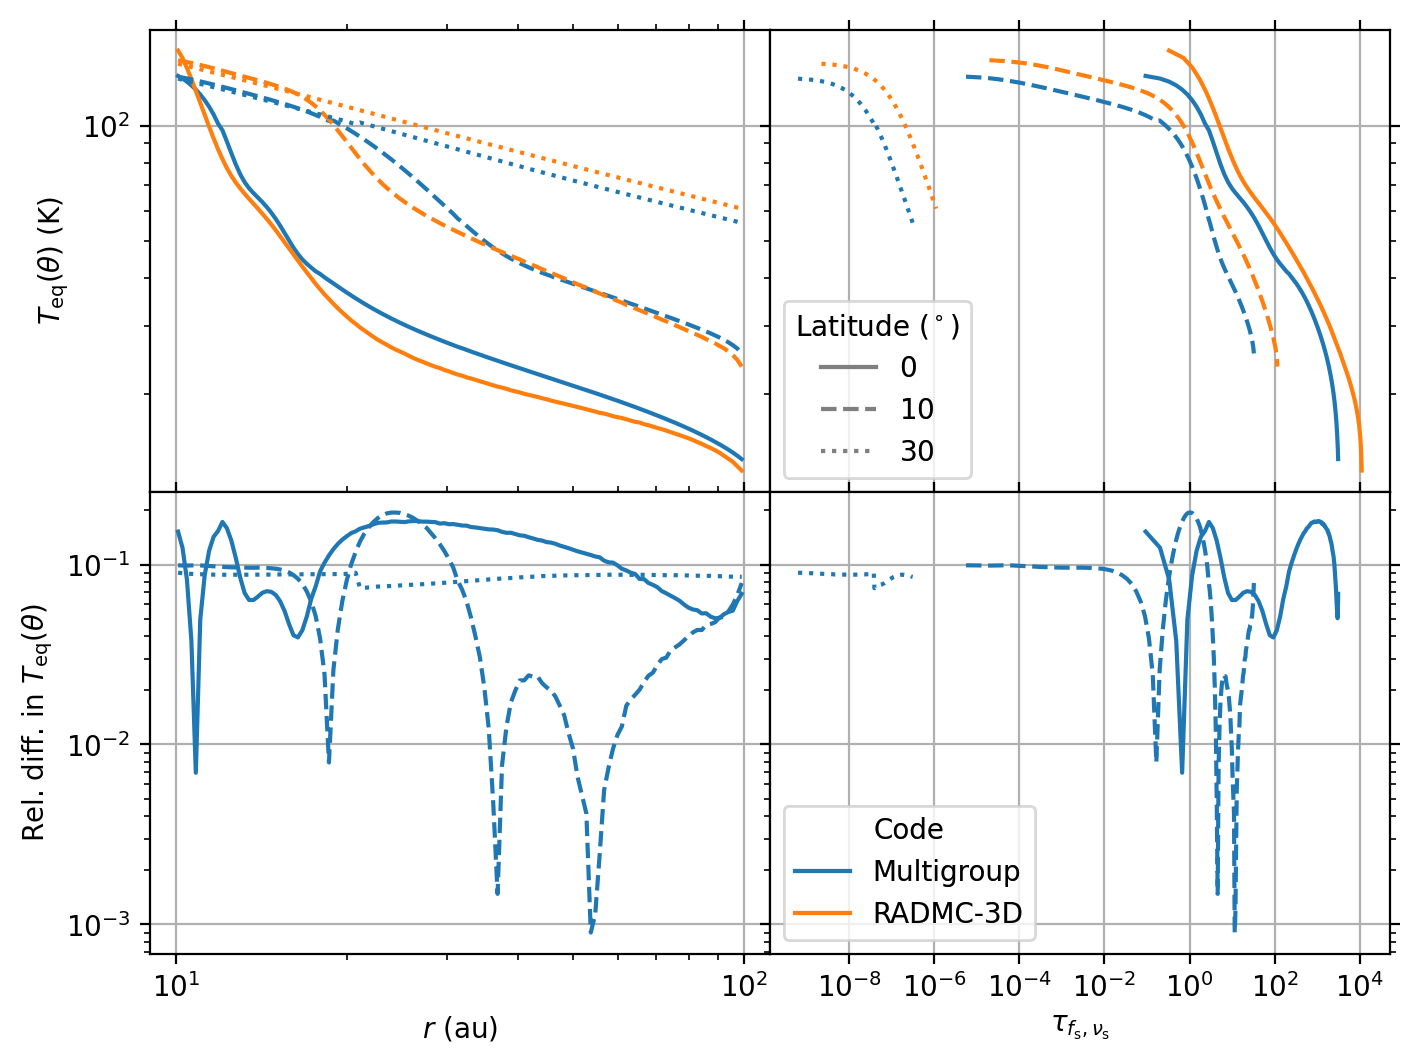

In [ ]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs-sca'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-sca/nfreq'
run = '3/v2'
f_star = 2
path = f'{base}/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
nx1 = athinput['mesh']['nx1']
nx2 = athinput['mesh']['nx2']
nzeta = athinput['radiation']['nzeta']
nfreq = athinput['radiation']['n_frequency']
length_unit = athinput['radiation']['length_unit']
T_unit = athinput['radiation']['T_unit']
L_au = length_unit/au
dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
         /athinput['mesh']['nx2']
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
dtau = (athdf[f'Sigma_a_{f_star}'][0] + athdf[f'Sigma_s_{f_star}'][0])\
       *np.diff(athdf['x1f'])
tau = np.cumsum(dtau, axis=1)
T_field = athdf['press'][0]/athdf['rho'][0]
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                    /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit, color='tab:blue',
                ls=lss[th])
    axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color='tab:orange', ls=lss[th])
    axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color='tab:blue',
                   ls=lss[th])
    axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color='tab:orange',
                   ls=lss[th])
    axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color='tab:blue',
                   ls=lss[th])
    axs[1][1].plot(tau[j, :], rel_diff_T, color='tab:blue', ls=lss[th])
    ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                 label=rf'${90-theta_deg}$')[0])
c_solns.append(axs[1][1].plot([], [], color='tab:blue', label=f'Multigroup')[0])
c_solns.append(axs[1][1].plot([], [], color='tab:orange', label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[1][1].add_artist(axs[1][1].legend(framealpha=0.56, handles=c_solns,
                                      title=r'Code'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)',
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_{f_\mathrm{s},\nu_\mathrm{s}}$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/optimized_profiles.pdf', bbox_inches='tight', pad_inches=0.01)

## Resolution Studies

### Frequency

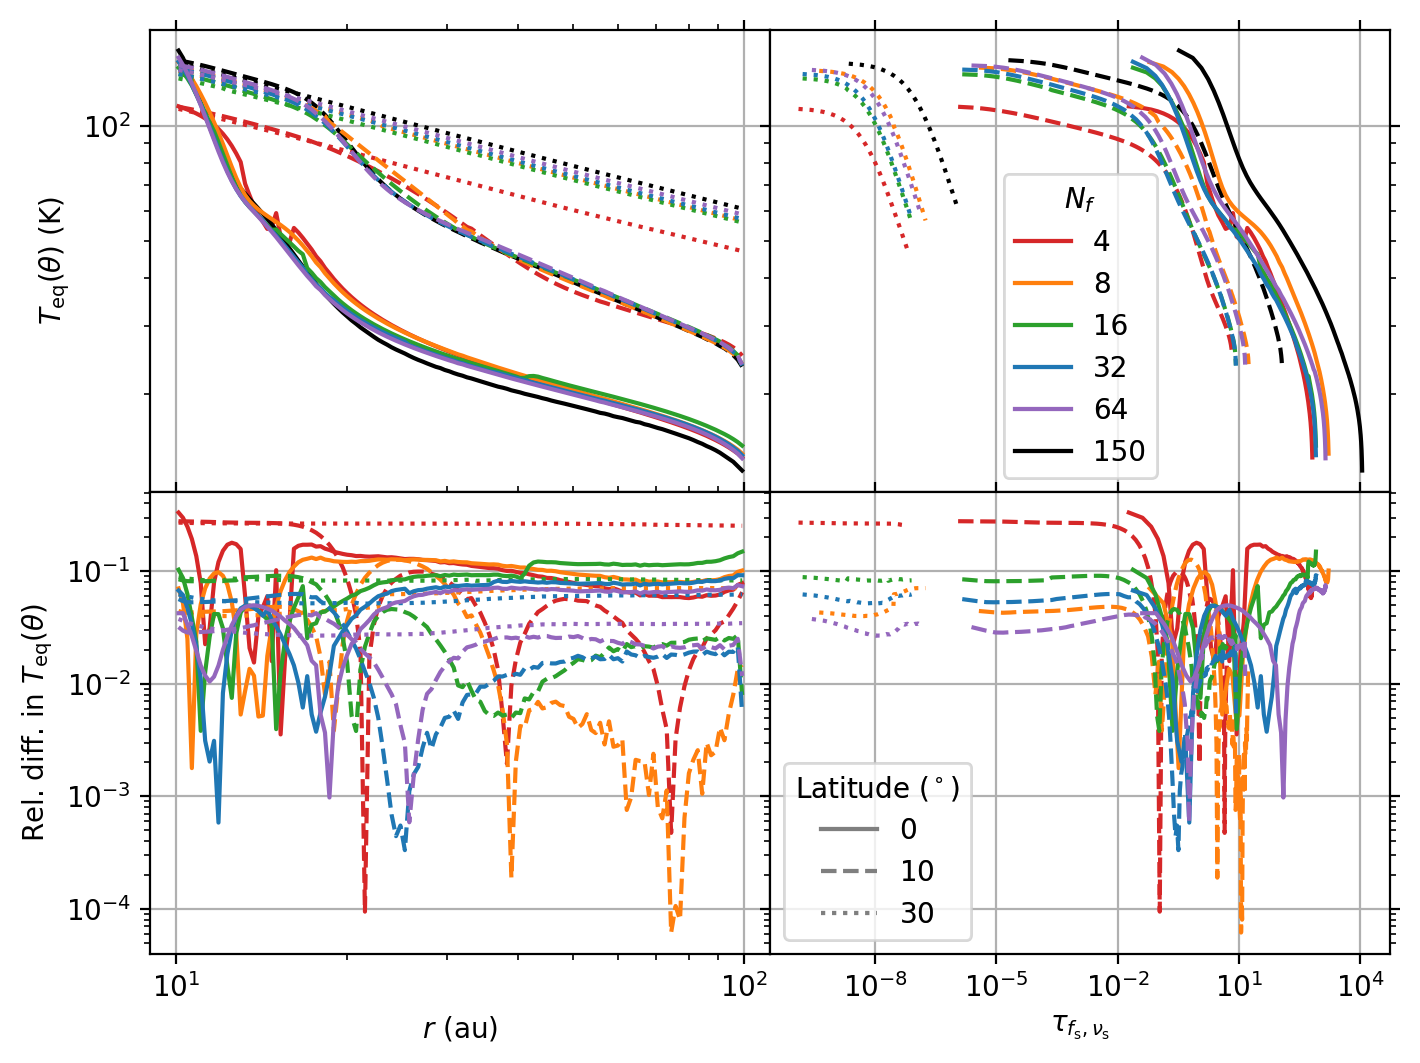

In [28]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs-sca'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-sca/nfreq'
runs = ['4', '8', '16', '32', '64']
bands = [3, 6, 13, 26, 54]
for i, run in enumerate(runs):
    path = f'{base}/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    nx1 = athinput['mesh']['nx1']
    nx2 = athinput['mesh']['nx2']
    nzeta = athinput['radiation']['nzeta']
    nfreq = athinput['radiation']['n_frequency']
    length_unit = athinput['radiation']['length_unit']
    T_unit = athinput['radiation']['T_unit']
    L_au = length_unit/au
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
            /athinput['mesh']['nx2']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    dtau = athdf[f'Sigma_a_{bands[i]}'][0]*np.diff(athdf['x1f'])
    tau = np.cumsum(dtau, axis=1)
    T_field = athdf['press'][0]/athdf['rho'][0]
    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                        /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
        axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit,
                       color=tab_colors[i], ls=lss[th])
        axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color=tab_colors[i],
                       ls=lss[th])
        axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color=tab_colors[i],
                       ls=lss[th])
        axs[1][1].plot(tau[j, :], rel_diff_T, color=tab_colors[i], ls=lss[th])
        if i == 0:
            axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color='black',
                           ls=lss[th])
            axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color='black',
                           ls=lss[th])
            ls_thetas.append(axs[0][1].plot([], [], color='tab:gray',
                             ls=lss[th], label=rf'${90-theta_deg}$')[0])
    c_solns.append(axs[1][1].plot([], [], color=tab_colors[i],
                   label=f'{run}')[0])
c_solns.append(axs[1][1].plot([], [], color='black', label='150')[0])

# Plot ghost points for colorless line style and add legends
axs[1][1].add_artist(axs[1][1].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      title='$N_f$'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)',
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_{f_\mathrm{s},\nu_\mathrm{s}}$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/nfreq.pdf', bbox_inches='tight', pad_inches=0.01)

### Angles

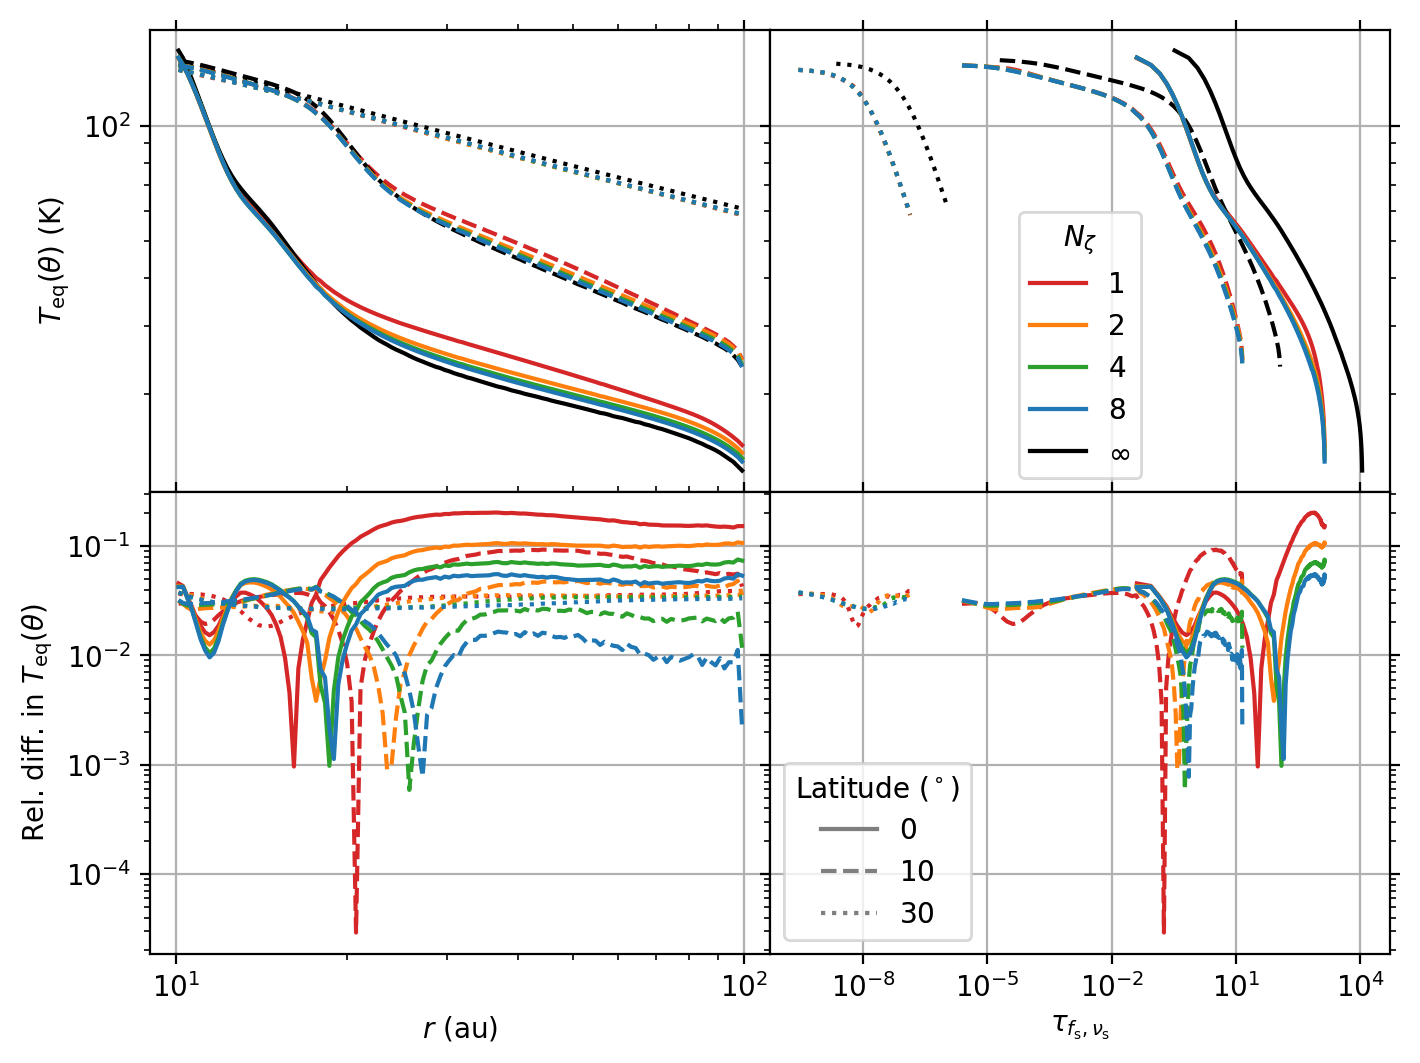

In [29]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs-sca'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-sca/nzeta'
runs = [1, 2, 4, 8]
band = 54
for i, run in enumerate(runs):
    path = f'{base}/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    nx1 = athinput['mesh']['nx1']
    nx2 = athinput['mesh']['nx2']
    nzeta = athinput['radiation']['nzeta']
    nfreq = athinput['radiation']['n_frequency']
    length_unit = athinput['radiation']['length_unit']
    T_unit = athinput['radiation']['T_unit']
    L_au = length_unit/au
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
            /athinput['mesh']['nx2']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    dtau = athdf[f'Sigma_a_{band}'][0]*np.diff(athdf['x1f'])
    tau = np.cumsum(dtau, axis=1)
    T_field = athdf['press'][0]/athdf['rho'][0]
    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                        /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
        axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit,
                       color=tab_colors[i], ls=lss[th])
        axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color=tab_colors[i],
                       ls=lss[th])
        axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color=tab_colors[i],
                       ls=lss[th])
        axs[1][1].plot(tau[j, :], rel_diff_T, color=tab_colors[i], ls=lss[th])
        if i == 0:
            axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color='black',
                           ls=lss[th])
            axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color='black',
                           ls=lss[th])
            ls_thetas.append(axs[0][1].plot([], [], color='tab:gray',
                             ls=lss[th], label=rf'${90-theta_deg}$')[0])
    c_solns.append(axs[1][1].plot([], [], color=tab_colors[i],
                   label=f'{run}')[0])
c_solns.append(axs[1][1].plot([], [], color='black', label=r'$\infty$')[0])

# Plot ghost points for colorless line style and add legends
axs[1][1].add_artist(axs[1][1].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      loc='lower center', title=r'$N_\zeta$'))

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)',
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_{f_\mathrm{s},\nu_\mathrm{s}}$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/nzeta.pdf', bbox_inches='tight', pad_inches=0.01)

## Performance

a_N_f = 4.11e+01, k_N_f = 1.10
a_N_z = 1.03e+03, k_N_z = 0.69


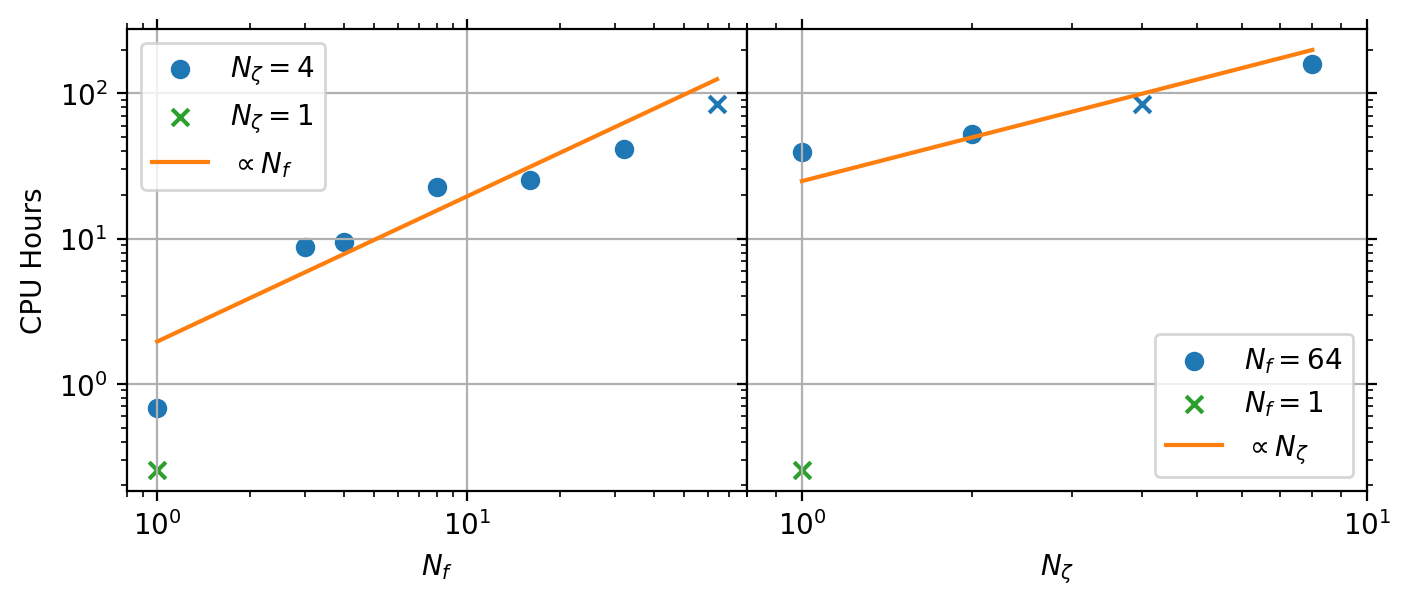

In [63]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Manually acquired data
cores = 128
shared_nfreq = 64
shared_nzeta = 4
shared_time = 2.3954686099999999e+03
nfreq = np.asarray([1, 3, 4, 8, 16, 32])
nzeta = np.asarray([1, 2, 8])
nfreq_times = np.asarray([1.9328275000000001e+01,
                          2.4462723399999999e+02,
                          2.6619104099999998e+02,
                          6.4109173899999996e+02,
                          7.0872024499999998e+02,
                          1.1663840140000000e+03])
nzeta_times = np.asarray([1.1115009540000001e+03,
                          1.4704507220000000e+03,
                          4.4908124760000001e+03])
root_nfreq = 1
root_nzeta = 1
root_time = 7.1832839999999996e+00


# Best fitting
def pow_law(N, a, k):
    return a*N**k
def lin_fit(x, b, m):
    return m*x + b
n = np.logspace(0, 2)
n2 = np.asarray([1, 64])
n3 = np.asarray([1, 8])
popt, pcov = curve_fit(lin_fit, np.log(nfreq), np.log(nfreq_times))
a_nfreq, k_nfreq = np.exp(popt[0]), popt[1]
popt, pcov = curve_fit(lin_fit, np.log(nzeta), np.log(nzeta_times))
a_nzeta, k_nzeta = np.exp(popt[0]), popt[1]
print(f'a_N_f = {a_nfreq:.2e}, k_N_f = {k_nfreq:.2f}')
print(f'a_N_z = {a_nzeta:.2e}, k_N_z = {k_nzeta:.2f}')

# Plot
fig, axs = plt.subplots(ncols=2, sharey='row', figsize=(8, 3), dpi=200)
axs[0].scatter(shared_nfreq, cores*shared_time/3600, color='tab:blue', marker='x')
axs[0].scatter(nfreq, cores*nfreq_times/3600, label=r'$N_\zeta = 4$')
axs[0].scatter(root_nfreq, cores*root_time/3600, color='tab:green', marker='x',
               label=r'$N_\zeta = 1$')
axs[0].plot(n2, pow_law(n2, cores*55/3600, 1), color='tab:orange', label=r'$\propto N_f$')
# axs[0].plot(n, pow_law(n, a_nfreq, k_nfreq), color='tab:orange', label='$aN_f^k$')
axs[1].scatter(shared_nzeta, cores*shared_time/3600, color='tab:blue', marker='x')
axs[1].scatter(nzeta, cores*nzeta_times/3600, label='$N_f = 64$')
axs[1].scatter(root_nzeta, cores*root_time/3600, color='tab:green', marker='x',
               label='$N_f = 1$')
axs[1].plot(n3, pow_law(n3, cores*700/3600, 1), color='tab:orange', label=r'$\propto N_\zeta$')

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.legend()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
# axs[0].legend(loc='upper left')
axs[0].set(xlabel='$N_f$', xlim=(0.8, 80), ylabel='CPU Hours')
axs[1].set(xlabel=r'$N_\zeta$', xlim=(0.8, 10), xticks=[1e0, 1e1])
fig.subplots_adjust(wspace=0)
plt.savefig('figs/performance.pdf', bbox_inches='tight', pad_inches=0.01)